In [39]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [5]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/'
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


## How to divide the train/val/test set

In [62]:
# Directory containing HDF5 files
INPUT_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_train"

# Get all HDF5 files in the input directory
files = list(Path(INPUT_DIR).glob("**/*.h5"))
file_count = 1
print(f"Found {len(files)} files in {INPUT_DIR}")
# Loop through each file and read the data
i=1
limit = 6
for file in files:
    print(file.name)
    i+=1
    if i > limit:
        break
last_152_files = files[-152:]
print(len(last_152_files))

Found 973 files in /DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_train
file1000059.h5
file1002000.h5
file1000560.h5
file1002293.h5
file1000663.h5
file1001523.h5
152


In [ ]:
# Directory containing HDF5 files
INPUT_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_train"

# Get all HDF5 files in the input directory
files2 = list(Path(INPUT_DIR).glob("**/*.h5"))
file_count = 1
print(f"Found {len(files)} files in {INPUT_DIR}")
# Loop through each file and read the data
i=1
limit = 6
for file in files2:
    print(file.name)
    i+=1
    if i > limit:
        break

Found 973 files in /DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_train
file1000059.h5
file1002000.h5
file1000560.h5
file1002293.h5
file1000663.h5
file1001523.h5


Only keep 821 first files, delete 152 last files:

In [71]:
path_CS_rec = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/"
path_CS_rec = Path(path_CS_rec)

# Loop through and remove matching files
for file in last_152_files:
    cs_name = file.name.replace('.h5', '_cs.npy')
    target_file = path_CS_rec / cs_name # Match by name only
    print(f"Checking: {target_file}")
    if target_file.exists():
        target_file.unlink()  # Deletes the file
        print(f"Removed: {target_file}")
    else:
        print(f"File not found in target directory: {target_file}")

Checking: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1002368_cs.npy
Removed: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1002368_cs.npy
Checking: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1000997_cs.npy
Removed: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1000997_cs.npy
Checking: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1002062_cs.npy
Removed: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1002062_cs.npy
Checking: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1001106_cs.npy
Removed: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1001106_cs.npy
Checking: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file1001733_cs.npy
Removed: /DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/file

In [75]:
INPUT_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train"

# Get all HDF5 files in the input directory
files = list(Path(INPUT_DIR).glob("**/*.h5"))
file_count = 1
print(f"Found {len(files)} files in {INPUT_DIR}")

files_train = files[1000:1847]
print(len(files_train))

Found 4458 files in /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train
847


## Check if all slices get cropped to correct size?!

In [30]:
from pathlib import Path
import numpy as np
import h5py
from fastmri.data import transforms as T
import torch
import torch.nn.functional as F

def downscale_bart_output(img_torch: torch.Tensor, target_size: tuple) -> torch.Tensor:
    """
    Downscale a BART output image (real or complex) from 640x640 to target_size.
    Assumes the input is a 2D complex-valued TENSOR of shape or (H, W, 2) = output of T.to_tensor
    """
    img_torch = img_torch.permute(2, 0, 1).unsqueeze(0)  # -> (1, 2, H, W)

    # Resize to 320x3taget_shape 20 using bilinear interpolation
    img_resized = F.interpolate(img_torch, target_size, mode='bilinear', align_corners=False)
    #img_resized = F.interpolate(img_torch, target_size, mode='area')

     # Convert back to (H, W, 2)
    img_resized = img_resized.squeeze(0).permute(1, 2, 0)  # -> (H, W, 2)

    return img_resized

data_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI'
bart_path= '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS'
data_path = Path(data_path)
bart_path = Path(bart_path)
dataslice = 0

root = data_path / "multicoil_val" 
bart_path_train = bart_path / "multicoil_train"
files = list(Path(bart_path_train).iterdir()) 
for fname_cs in sorted(files):
    ## FIRST: GET FNAME
    fname_stem = fname_cs.stem 
    fname_stem = fname_stem.replace("_cs", "") 
    # get brain or knee folder
    if "brain" in str(fname_stem):
        # root now looks like /path/to/NYU_FastMRI/multicoil_...
        folder = Path(root).parent / "Preprocessed/" 
    else:
        folder = Path(root).parent/ "Knee/" 
    # since BART train/val/test set is different from original fastmri one 
    # need to check all folders of fastmri!!
    for subset in ["multicoil_train", "multicoil_val", "multicoil_test"]:
        folder_sub = folder / subset
        fname = folder_sub / (fname_stem + ".h5")
        if fname.exists():
            #print(f"Found original file: {fname}")
            break                       
    assert fname.exists()

    ## NOW: CHECK FILE CROPPING
    
    with h5py.File(fname, "r") as hf:
            orig_shape = (hf["kspace"][dataslice].shape[1], hf["kspace"][dataslice].shape[2])
            # mask = np.asarray(hf["mask"]) if "mask" in hf else None
            target = hf["reconstruction_rss"][dataslice] if "reconstruction_rss" in hf else None

            attrs = dict(hf.attrs)
    
    image = np.load(fname_cs)
    image = T.to_tensor(image[dataslice])
    image = downscale_bart_output(image, orig_shape)
    # crop input to correct size
    if target is not None:
        crop_size = (target.shape[-2], target.shape[-1])
    else:
        crop_size = (attrs["recon_size"][0], attrs["recon_size"][1])

    # check for FLAIR 203 (use orig_shape here instead of image cause not downscaled yet)
    if image.shape[-2] < crop_size[1]:
        crop_size = (image.shape[-2], image.shape[-2])

    if crop_size[0] != 320 or crop_size[1] != 320:
        print(f'cropsize of file {fname} is not 320x320, it is {crop_size[0]}x{crop_size[1]}')

    image = T.complex_center_crop(image, crop_size)

cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_201_6002894.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_201_6002980.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000436.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000437.h5 is not 320x320, it is 320x300
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000455.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000456.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000472.h5 is not 320x320,

In [24]:
print(image.shape)
print(image.shape[-3])

torch.Size([320, 320, 2])
320


cropsize of file file_brain_AXT2_203_2030302.h5 is not 320x320, it is 384x384

cropsize of file file_brain_AXT2_203_2030012.h5 is not 320x320, it is 384x384

cropsize of file file_brain_AXFLAIR_202_6000524.h5 is not 320x320, it is 320x260

cropsize of file file_brain_AXFLAIR_203_6000957.h5 is not 320x320, it is 234x234

cropsize of file file_brain_AXT2_209_2090074.h5 is not 320x320, it is 384x384

In [38]:
file_error = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_201_6002894.h5" #  is not 320x320, it is 320x260
file_error = Path(file_error)
with h5py.File(file_error, "r") as hf:
    print(hf["kspace"][dataslice].shape)
    target = hf["reconstruction_rss"][dataslice] if "reconstruction_rss" in hf else None
    print(target.shape)
    

(16, 640, 262)
(320, 260)


cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_201_6002894.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_201_6002980.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000436.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000437.h5 is not 320x320, it is 320x300
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000455.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000456.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000472.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000522.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000524.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000539.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000557.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000561.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000579.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000581.h5 is not 320x320, it is 256x208
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000584.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_202_6000590.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000901.h5 is not 320x320, it is 213x213
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000908.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000913.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000918.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000922.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000927.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000940.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000941.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000942.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000955.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000957.h5 is not 320x320, it is 234x234
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_203_6000961.h5 is not 320x320, it is 276x276
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_206_6000241.h5 is not 320x320, it is 256x224
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_206_6000250.h5 is not 320x320, it is 256x224
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_206_6000256.h5 is not 320x320, it is 256x224
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1POST_201_6002752.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1POST_202_6000300.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1POST_205_2050265.h5 is not 320x320, it is 320x260
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000275.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000284.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000342.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000374.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000382.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000445.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000490.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT1_202_6000534.h5 is not 320x320, it is 320x270
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000023.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000028.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000042.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000044.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000060.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000073.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000075.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000099.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000113.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000123.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000139.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000140.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000141.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000149.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000176.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000189.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000198.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000322.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000332.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000390.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000394.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000400.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000409.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000415.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000425.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000428.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000431.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000447.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000453.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000469.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000471.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000472.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000490.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000491.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000496.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000507.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000511.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000512.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000520.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000522.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000524.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000528.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000550.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000566.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000576.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000592.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000600.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_2000625.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6001958.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6001960.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6001968.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6001971.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6001980.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6001985.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002015.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002019.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002066.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002094.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002096.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002114.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002119.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002142.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002143.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002144.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002146.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002163.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002202.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002210.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002211.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002214.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002231.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002235.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002238.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002246.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002261.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002262.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002273.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002290.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002317.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002347.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002356.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002362.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002381.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002406.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002432.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002445.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002450.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002455.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002463.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002475.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002476.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002494.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002515.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002528.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002535.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002539.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002550.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002580.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002587.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002599.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002609.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002610.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002615.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002626.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002632.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_200_6002642.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010004.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010014.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010017.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010027.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010029.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010035.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010045.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010046.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010054.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010067.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010068.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010083.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010089.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010104.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010113.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010126.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010148.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010165.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010187.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010215.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010268.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010323.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010338.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010348.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010349.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010381.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010394.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010398.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010400.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010401.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010404.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010410.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010413.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010419.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010424.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010427.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010441.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010444.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010455.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010480.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010498.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010509.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010517.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010525.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010537.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010553.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010565.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010568.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010572.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010576.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010578.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010584.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010585.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010586.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010616.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010624.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010625.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010626.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_2010632.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_201_6002961.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030012.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030067.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030086.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030131.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030199.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030201.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030242.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030248.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030266.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030298.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030302.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030316.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030317.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030320.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030352.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030354.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030380.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030387.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030401.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_203_2030404.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040011.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040027.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040033.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040035.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040040.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040042.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040056.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040058.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040059.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040065.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040073.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040086.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040091.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_204_2040092.h5 is not 320x320, it is 384x312
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090008.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090011.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090022.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090028.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090040.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090051.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090062.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090074.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090102.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090107.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090109.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090111.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090117.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090120.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090129.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090137.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090156.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090175.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090202.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090207.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090214.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090219.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090230.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090232.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090243.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090261.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090270.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090280.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090300.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090302.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090312.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090314.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090341.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090348.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090377.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090387.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090388.h5 is not 320x320, it is 384x312
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090390.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090402.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090406.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090408.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090410.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_2090418.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6000970.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6000977.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001011.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001023.h5 is not 320x320, it is 384x324
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001047.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001060.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001079.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001080.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001087.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001093.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001099.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001135.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001137.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001148.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001165.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001190.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001215.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001273.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001284.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001298.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001299.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001304.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001317.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001321.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001327.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001333.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001334.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001345.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001347.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001371.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001384.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001396.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001398.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001405.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001409.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001415.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001436.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001442.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001443.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_209_6001461.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100016.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100017.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100052.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100078.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100084.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100094.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100120.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100147.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100160.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100175.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100182.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100194.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100201.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100224.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100233.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100243.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100251.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100268.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100280.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100281.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100295.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100302.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100331.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100332.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100346.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100350.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100353.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100359.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100364.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100370.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100384.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_2100415.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001514.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001518.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001522.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001532.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001534.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001543.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001558.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001559.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001562.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001566.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001571.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001584.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001586.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001594.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001631.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001633.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001634.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001658.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001677.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001686.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001691.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001697.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001700.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001711.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001726.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001742.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001744.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001756.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001763.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001773.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001784.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001796.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001814.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001815.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001830.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001833.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001847.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001849.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001854.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001859.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001886.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001890.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001923.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001931.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001944.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001951.h5 is not 320x320, it is 384x384
cropsize of file /DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXT2_210_6001952.h5 is not 320x320, it is 384x384

## Compare new CS output to previous brain CS output (preprocessed_transforms.py test)

“We validated that bilinear downscaling of CS outputs did not significantly alter structural information, with SSIM > 0.95 on multiple test cases.”

In [124]:
## original CS data
#fname_brain = 'file_brain_AXFLAIR_209_6001413.h5'
# fname_brain = 'file_brain_AXT2_210_6001633.h5'
fname_brain = 'file_brain_AXT1PRE_205_6000063.h5'
original_brain = h5py.File(os.path.join(train_path, fname_brain), 'r')
original_CS = original_brain['cs_data'][()]
print('Original CS shape:', original_CS.shape)
# new CS data 640x640
CS_path = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/multicoil_train/'
new_CS = np.load(CS_path + fname_brain.replace('.h5','') + '_cs.npy' )
print('New CS shape:', new_CS.shape)


Original CS shape: (16, 640, 320)
New CS shape: (16, 640, 640)


Plot to make sure they have the same acceleration factor (random done in training data!)

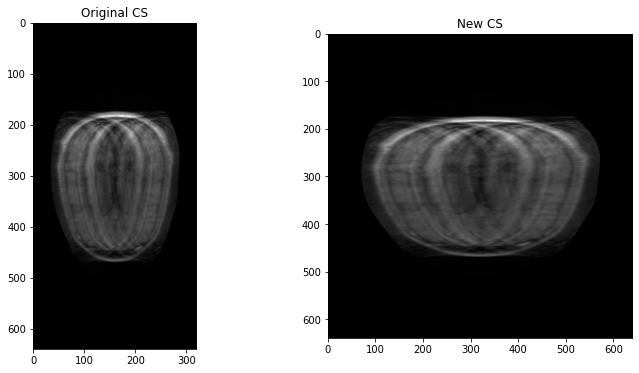

In [129]:
slice_idx = 1
# plot original and new side by side
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(np.abs(original_CS[slice_idx]), cmap='gray')
ax[0].set_title('Original CS')
ax[1].imshow(np.abs(new_CS[slice_idx]), cmap='gray')
ax[1].set_title('New CS')
plt.show()

Rescale new CS to match old_CS and compare

(640, 320)


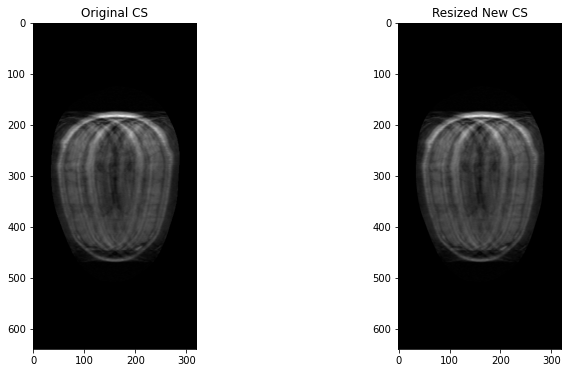

In [130]:
import torch.nn.functional as F
import torch 

def downscale_bart_output(img: np.ndarray, target_size) -> np.ndarray:
    """
    Downscale a BART output image (real or complex) from 640x640 to 320x320.
    Assumes the input is a 2D real-valued image (magnitude) or complex-valued image.
    """
    # Convert to torch tensor
    img_torch = torch.tensor(img)

    # If complex, convert to 2-channel
    if torch.is_complex(img_torch):
        img_torch = torch.view_as_real(img_torch).permute(2, 0, 1).unsqueeze(0)  # (1, 2, H, W)
    else:
        img_torch = img_torch.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

    # Resize to 320x320 using bilinear interpolation
    img_resized = F.interpolate(img_torch, target_size, mode='bilinear', align_corners=False)
    #img_resized = F.interpolate(img_torch, target_size, mode='area')

    # Squeeze back
    img_resized = img_resized.squeeze(0)  # (C, H, W)

    # Return as numpy array
    if img_resized.shape[0] == 2:
        return torch.view_as_complex(img_resized.permute(1, 2, 0).contiguous()).numpy()  # (H, W)
    else:
        return img_resized.squeeze(0).numpy()

# resize new CS image to 640x320
target_size = (original_CS.shape[1], original_CS.shape[2])
resized_new_CS = downscale_bart_output(new_CS[slice_idx], target_size)
print(resized_new_CS.shape)
# plot resized new CS
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(np.abs(original_CS[slice_idx]), cmap='gray')
ax[0].set_title('Original CS')
ax[1].imshow(np.abs(resized_new_CS), cmap='gray')
ax[1].set_title('Resized New CS')
plt.show()

Do current preprocessed_transforms transformations on them and look at diff:

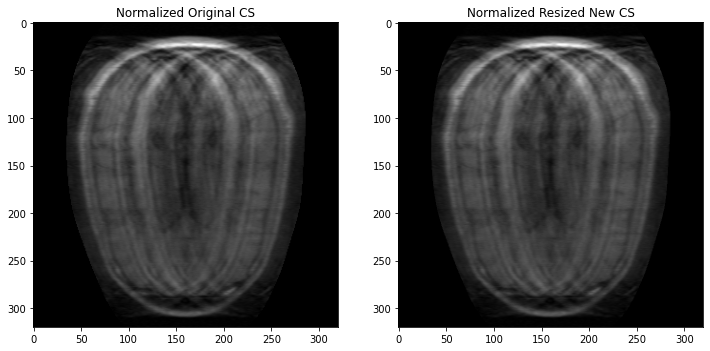

In [110]:
from fastmri.data import transforms as T
import fastmri
prep_orig_CS = T.to_tensor(original_CS[slice_idx])
prep_new_CS = T.to_tensor(resized_new_CS)

prep_orig_CS = T.complex_center_crop(prep_orig_CS, (320, 320))
prep_new_CS = T.complex_center_crop(prep_new_CS, (320, 320))

prep_orig_CS = fastmri.complex_abs(prep_orig_CS)
prep_new_CS = fastmri.complex_abs(prep_new_CS)

prep_orig_CS, mean, std = T.normalize_instance(prep_orig_CS, eps=1e-11)
prep_orig_CS = prep_orig_CS.clamp(-6, 6)
prep_new_CS, mean, std = T.normalize_instance(prep_new_CS, eps=1e-11)
prep_new_CS = prep_new_CS.clamp(-6, 6)

# plot normalized original and new CS side by side
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(prep_orig_CS, cmap='gray')
ax[0].set_title('Normalized Original CS')
ax[1].imshow(prep_new_CS, cmap='gray')
ax[1].set_title('Normalized Resized New CS')
plt.show()


In [111]:
print('datatype original:', prep_orig_CS.dtype)
print('datatype new:' , prep_new_CS.dtype)



datatype original: torch.float32
datatype new: torch.float32


In [112]:
from skimage.metrics import structural_similarity as ssim
def compute_ssim(image1: np.ndarray, image2: np.ndarray) -> float:
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    
    Args:
        image1: First image (numpy array)
        image2: Second image (numpy array)
        
    Returns:
        SSIM value
    """
    return ssim(image1, image2, data_range=image1.max())
# Compute SSIM
ssim_value = compute_ssim(prep_orig_CS.numpy(), prep_new_CS.numpy())
print("SSIM between original and resized new CS:", ssim_value)

SSIM between original and resized new CS: 0.9930236091987454


1.0


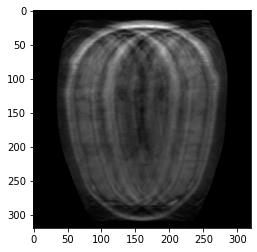

In [138]:
## short view of transforms:
def downscale_bart_output(img_torch: torch.Tensor, target_size: tuple) -> torch.Tensor:
    """
    Downscale a BART output image (real or complex) from 640x640 to target_size.
    Assumes the input is a 2D complex-valued TENSOR of shape or (H, W, 2) = output of T.to_tensor
    """
    img_torch = img_torch.permute(2, 0, 1).unsqueeze(0)  # -> (1, 2, H, W)

    # Resize to 320x3taget_shape 20 using bilinear interpolation
    img_resized = F.interpolate(img_torch, target_size, mode='bilinear', align_corners=False)
    #img_resized = F.interpolate(img_torch, target_size, mode='area')

     # Convert back to (H, W, 2)
    img_resized = img_resized.squeeze(0).permute(1, 2, 0)  # -> (H, W, 2)

    return img_resized
new_CS_slice = new_CS[slice_idx]

new_CS_slice = T.to_tensor(new_CS_slice)

new_CS_slice = downscale_bart_output(new_CS_slice, (original_CS.shape[1], original_CS.shape[2]))

crop_size= (320, 320)
new_CS_slice = T.complex_center_crop(new_CS_slice, crop_size)

new_CS_slice = fastmri.complex_abs(new_CS_slice)

new_CS_slice, mean, std = T.normalize_instance(new_CS_slice, eps=1e-11)
new_CS_slice = new_CS_slice.clamp(-6, 6)

# plot new_cs_slice
plt.imshow(new_CS_slice.numpy(), cmap='gray')

print(compute_ssim(new_CS_slice.numpy(), prep_new_CS.numpy()))


## Check mri_data.py changes

In [60]:
from pathlib import Path
import torch

root = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/'
files = list(Path(root).iterdir())
for fname in sorted(files):
    print(fname)
    print(fname.stem)
    break

slice_num = 13 

bart_file = np.load(fname)
print(bart_file.shape)
cs_data = bart_file[slice_num]
print(cs_data.shape)

rss_dir = '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Full_RSS_target/'
print(fname.stem)
rss_filename = fname.stem.replace('_cs', '_rss') + '.pt'
print(rss_filename)
target_shape = target = torch.load(rss_dir + rss_filename)['orig_shape']
target = torch.load(rss_dir + rss_filename)['image'][slice_num].numpy()
print(target.shape)



/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Preprocessed_CS/file1000001_cs.npy
file1000001_cs
(36, 640, 640)
(640, 640)
file1000001_cs
file1000001_rss.pt
(640, 640)


## Transforms.py TESTS

In [131]:
import os
from fastmri.data import transforms as T
import fastmri
from typing import NamedTuple

class UnetSample(NamedTuple):
    """
    A subsampled image for U-Net reconstruction.

    Args:
        image: Subsampled image after inverse FFT.
        target: The target image (if applicable).
        mean: Per-channel mean values used for normalization.
        std: Per-channel standard deviations used for normalization.
        fname: File name.
        slice_num: The slice index.
        max_value: Maximum image value.
    """

    image: torch.Tensor
    target: torch.Tensor
    mean: torch.Tensor
    std: torch.Tensor
    fname: str
    slice_num: int
    #max_value: float

## GIVEN
# from above (mri_data): cs_data, target, fname, slice_num

##
image = T.to_tensor(cs_data)

# absolute value
image = fastmri.complex_abs(image)

# normalize input
image, mean, std = T.normalize_instance(image, eps=1e-11)
image = image.clamp(-6, 6)

# preprocess target if given
if target is not None:
    target_torch =  T.to_tensor(target)
    target_torch =  T.normalize(target_torch, mean, std, eps=1e-11)
    #target_torch, mean2, std2 = T.normalize_instance(target_torch, eps=1e-11)
    target_torch = target_torch.clamp(-6, 6)
else:
    target_torch = torch.Tensor([0])

# UnetSample(
#     image=image,
#     target=target_torch,
#     mean=mean,
#     std=std,
#     fname=fname,
#     slice_num=slice_num,
#     # max_value=max_value,
# )

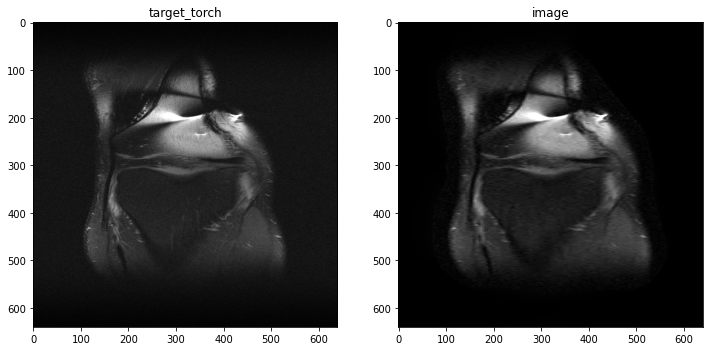

In [132]:
# plot target torch and image next to each other
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(target_torch, cmap='gray')
plt.title('target_torch')
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.title('image')
plt.show()

file1000001.h5
(320, 320)


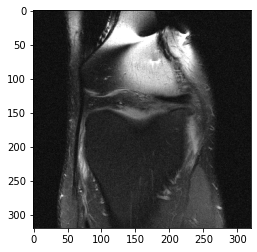

In [133]:
## compare to original reconstruction
hf_filename = fname.stem.replace('_cs', '') + '.h5'
print(hf_filename)
path_knee = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee/multicoil_train/"
hf = h5py.File(path_knee + hf_filename, 'r')
orginal_rss = hf['reconstruction_rss'][slice_num]
print(orginal_rss.shape)
# first normalize as well
original_rss_torch =  T.to_tensor(orginal_rss)
original_rss_torch =  T.normalize(original_rss_torch, mean, std, eps=1e-11)
original_rss_torch = original_rss_torch.clamp(-6, 6)

plt.imshow(original_rss_torch, cmap='gray')

Looks already alike, but a lot brighter? maybe because of normalization? Lets see when rescaled:

(was because I normalized the target and the original rss by fastmri, has worse results than doing minimax normalization of both at the end (when both are same size...))

note on normalization: 
- it is important that we normalize_instance of CS output and then use these values to ensure input and target are on same scale WITHOUT TARGET LEAKAGE
- if you use normalize instance on target: leak information about target for model!!

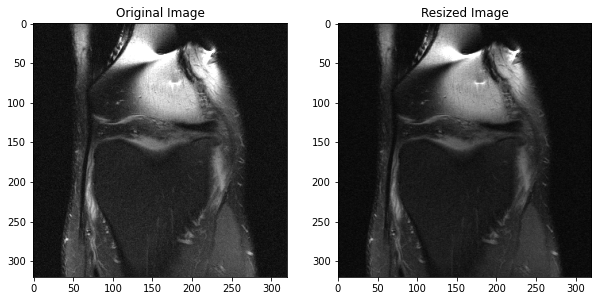

In [136]:
import torch.nn.functional as F
## Rescale an Image to the Original Shape
def resize_image(image: torch.Tensor, target_size: tuple) -> torch.Tensor:
    """
    Resize a 2D image tensor to a target size using bilinear interpolation.

    Args:
        image: Image tensor of shape (H, W) or (1, H, W)
        target_size: Tuple (new_h, new_w)

    Returns:
        Resized image tensor
    """
    if image.dtype == np.ndarray: # given is RSS reconstruction= numpy array of (H, W)
        # Convert to tensor and add batch and channel dimensions
        image = T.to_tensor(image)
    
    if image.ndim == 2:
        # Add batch and channel dimensions
        image = image.unsqueeze(0).unsqueeze(0)  # shape (1, 1, H, W)

    elif image.ndim == 3: # given is output of network= torch tensor of (1, H, W)
        # Add batch dimension
        image = image.unsqueeze(0)  # shape (1, 1, H, W) or (1, C, H, W)

    resized = F.interpolate(image, size=target_size, mode='bilinear', align_corners=False)
    return resized.squeeze()  # remove added batch and channel dims if needed

target_resized = resize_image(target_torch, target_shape)
target_resized = T.center_crop(target_resized, (320, 320))

# plot original and resized next to each other:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_rss_torch.numpy(), cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(target_resized.numpy(), cmap='gray')
ax[1].set_title('Resized Image')
plt.show()

In [135]:
## min max normalize both and compute ssim
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def compute_ssim(image1: np.ndarray, image2: np.ndarray) -> float:
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    
    Args:
        image1: First image (numpy array)
        image2: Second image (numpy array)
        
    Returns:
        SSIM value
    """
    return ssim(image1, image2, data_range=image1.max())
# ensure both same datatype + range before computing ssim
original_rss_ssim = original_rss_torch.numpy().astype(np.float32)
target_ssim= target_resized.numpy().astype(np.float32)
# Normalize images to [0, 1]
original_rss_ssim = (original_rss_ssim - original_rss_ssim.min()) / (original_rss_ssim.max() - original_rss_ssim.min())
target_ssim = (target_ssim - target_ssim.min()) / (target_ssim.max() - target_ssim.min())

# Compute SSIM
ssim_value = compute_ssim(original_rss_ssim, target_ssim)
print(f"SSIM between original and resized images: {ssim_value:.4f}")



SSIM between original and resized images: 0.0987


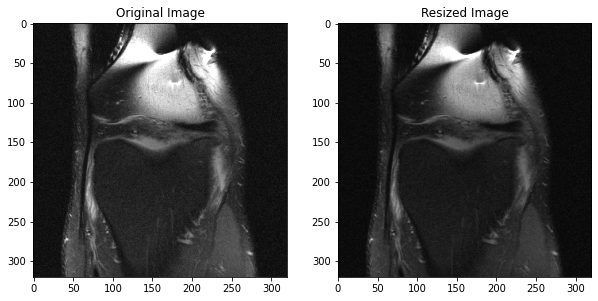

In [130]:
# plot original and resized next to each other:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_rss_ssim, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(target_ssim, cmap='gray')
ax[1].set_title('Resized Image')
plt.show()

## CHECK IF KNEE CS RECONSTRUCTIONS LOOK OK!

Shape of the data: (38, 640, 640)
Data type: complex64
Shape of the data: (640, 640)


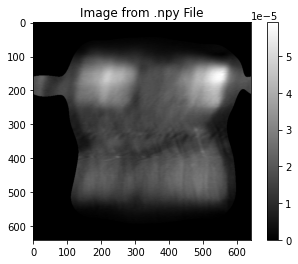

In [ ]:

path = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/knee_train"

# Select a file and save in hf
file_name = 'file1000059_cs.npy'
data = np.load(os.path.join(path, file_name), 'r')

# Print the shape and data type of the array
print("Shape of the data:", data.shape)
print("Data type:", data.dtype)

data_slice1 = data[36,:,:]
print("Shape of the data:", data_slice1.shape)

# Assuming 'data' is a 2D array (image)
plt.imshow(np.abs(data_slice1), cmap='gray')  # Use 'gray' for grayscale images
plt.colorbar()  # Add a color bar to show the scale
plt.title('Image from .npy File')
plt.show()

## Original PREPROCESSING

Look at keys and attributes of files in training data/ validation data / test data

(only test data that is not fully sampled has "acceleration" as attrs and a "mask" in keys)

In [57]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')


In [62]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
print('shape:', hf['kspace'].shape)
print('Shape:', hf['cs_data'].shape)


Keys: ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss', 'sense_data']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}
shape: (16, 20, 640, 320)
Shape: (16, 640, 320)


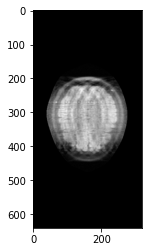

In [63]:
import matplotlib.pyplot as plt
slice6 = hf['cs_data'][6,:,:]
plt.imshow(np.abs(slice6), cmap='gray')  # Use 'gray' for grayscale images

In [45]:
file_name = 'file_brain_AXFLAIR_200_6002447.h5'
hf = h5py.File(os.path.join(validation_path, file_name), 'r')


In [6]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss', 'sense_data']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.00041413615952341293, 'norm': 0.08723472457184536, 'patient_id': '30c14259008242f60e5214a793bad574fbf48a7140f76ec3152eef31e090486d'}


In [7]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(test_path, file_name), 'r')


In [8]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'mask', 'sense_data']
Attrs: {'acceleration': 8, 'acquisition': 'AXFLAIR', 'num_low_frequency': 13, 'patient_id': 'ca18fce12f2549e69a2db3c660a4d27b116cd79c6ee2437a15db40db7379c723'}


In [5]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name), 'r')


In [10]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0003919748921278401, 'norm': 0.08606309877132198, 'patient_id': '6002441'}


Get CS mask data

In [7]:
# Real-life CS mask data
import scipy.io as sio
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()


dict_keys(['__header__', '__version__', '__globals__', 'm256_CS1_mask', 'm256_CS2_mask', 'm256_CS4_mask', 'm256_CS6_mask', 'm256_CS8_mask', 'm256_full_mask', 'm320_CS1_mask', 'm320_CS2_mask', 'm320_CS4_mask', 'm320_CS6_mask', 'm320_CS8_mask', 'm320_full_mask'])

Here, we can test our preprocessing approach for training and validation data

In [ ]:
#file_name = 'file_brain_AXFLAIR_200_6002425.h5'
preprocessed_train_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train'
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Opens in append mode! 'a' instead of 'r'
# CANT WRITE TO FILES OF NYU DATASET, HAVE TO STORE RESULTS YOURSELF


OSError: Unable to create file (unable to open file: name = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train/file_brain_AXFLAIR_200_6002447.h5', errno = 13, error message = 'Permission denied', flags = 15, o_flags = c2)

In [11]:
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))


Shape of the raw kspace:  (16, 16, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [12]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual CS undersampling pattern for the actual reconstruction pipeline itself

## Create ACS masked space for S_i
from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!


In [13]:
print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))


Shape of the generated mask:  torch.Size([1, 1, 1, 320, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [14]:
## create real world CS undersampling 

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

mask = generate_array(kspace.shape, 4, mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [15]:
print("Shape of the generated mask: ", str(mask.shape))
print("Datatype of the generated mask: ", str(type(mask)))


Shape of the generated mask:  (1, 1, 1, 320)
Datatype of the generated mask:  <class 'numpy.ndarray'>


In [16]:
# Now, let's preform a slice-wise ESPIRiT and CS estimation (TAKES LONG CAUSE IS FOR ALL SLICES!!)

import bart

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

cs_data = np.zeros((kspace.shape[0], kspace.shape[2], kspace.shape[3]), dtype=np.complex64)

for slice in range(kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])   # with ACS region!
    cs_data[slice,:,:] = CS(masked_kspace[slice,:,:,:], S)          # with real life CS_kspace

print("Shape of the numpy-converted CS data: ", str(cs_data.shape))
print("Type of the numpy-converted CS data: ", str(type(cs_data)))


Shape of the numpy-converted CS data:  (16, 640, 320)
Type of the numpy-converted CS data:  <class 'numpy.ndarray'>


In [ ]:
plt.imshow(np.abs(cs_data[10,:,:]), cmap='gray')

## TEST ZERO-PADDING before/after BART:

Select a file

In [69]:
# Select a file and save in hf
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')

How does it work for files of size (768, 396), where we cut the FE direction to 640??

file names to test:
file_brain_AXT2_209_2090111.h5

file_brain_AXT2_200_2000507.h5

file_brain_AXT2_200_6002445.h5

file_brain_AXT2_200_2000469.h5

file_brain_AXT2_201_2010349.h5

file_brain_AXT2_201_2010029.h5

file_brain_AXT2_210_2100332.h5

file_brain_AXT2_200_6002214.h5

file_brain_AXT2_210_6001756.h5


In [ ]:
file_name = "file_brain_AXT2_200_6002214.h5"
hf = h5py.File(os.path.join(train_path, file_name), 'r')



Get k-space + create masked_versions of k-space

In [70]:
# Get k-space
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))

Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


Shape kspace = (number of slices, number of coils, height, width)

In [1]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual CS undersampling pattern for the actual reconstruction pipeline itself

## Create ACS masked space for S_i
from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!

print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))

NameError: name 'kspace' is not defined

In [46]:
## create real world CS undersampling 
# SELECT ACCELERATION FACTOR
R = 4

# get Real-life CS mask data
import scipy.io as sio
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

mask = generate_array(kspace.shape, R, mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0

PERFORM BART reconstructions with zero-padded k-space (before and after )

Processing middle slice: 8
Method 1: Zero-padding k-space before BART
(16, 640, 640)
(16, 640, 640)
Method 1 execution time: 30.9188 seconds
Method 1 output shape: (640, 640)
Method 2: BART reconstruction first, then sinc interpolation
(1, 640, 640)
Method 2 execution time: 25.2013 seconds
Method 2 output shape: (640, 640)

Time comparison:
Method 1 (k-space zero-padding before BART): 30.9188 seconds
Method 2 (BART then sinc interpolation): 25.2013 seconds
Difference: 5.7175 seconds
Method 2 is faster
Mean absolute difference between methods: 2.780918475764338e-05
Max absolute difference between methods: 0.0006052551907487214


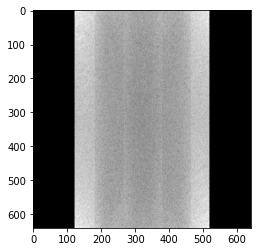

In [ ]:
import bart
import numpy as np
import time
import torch
from scipy.fft import ifft2, fft2

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
        # -S = rescale image after reconstrucition
        # -l1 = l1 wavelet (other option is l2 regularization)
        # -r lambda = regularization parameter
        # -i iter = max number of iterations
    return reconstruction

def zero_pad_kspace(kspace, target_size):
    """
    Zero-pad k-space to achieve sinc interpolation in image domain
    
    Args:
        kspace (numpy.array): K-space data (can be 2D or 3D with num_coils)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        kspace_padded (numpy.array): Zero-padded k-space
    """
    is_3d = len(kspace.shape) == 3  # Check if num_coils dimension exists
    if not is_3d:
        kspace = kspace[np.newaxis, ...]  # Add dummy coil dimension

    rows, cols = kspace.shape[-2], kspace.shape[-1]
    target_rows, target_cols = target_size

    # Convert k-space to fastMRI expected format (real, imag) -> shape (num_coils, rows, cols, 2)
    kspace_tensor = T.to_tensor(kspace)

     # Handle cropping if the size is too large
    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows = target_rows
        cols = target_cols

     # if only 1 dimension is too large, crop that dimension   
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    # Handle zero-padding if the size is too small
    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        
        # Apply zero padding to 3D array
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor)
    print(kspace_padded.shape)
    return kspace_padded if is_3d else kspace_padded[0]  # Remove dummy coil dimension if needed

def image_domain_zero_pad(image, target_size):
    """
    Perform sinc interpolation by IFT, zero-padding, FT
    
    Args:
        image (numpy.array): Image domain data (rows, cols)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        interpolated_image (numpy.array): Sinc interpolated image
    """
    # Convert to k-space
    kspace = fft2(image)
    
    # Zero-pad or crop k-space
    adjusted_kspace = zero_pad_kspace(kspace, target_size)

    #plt.imshow(padded_kspace, cmap='gray')
    plt.imshow(np.log(1e-7 + np.abs(adjusted_kspace)), cmap='gray')
    
    # Convert back to image domain
    interpolated_image = ifft2(adjusted_kspace)
    
    return interpolated_image

# Select the middle slice

print(f"Processing middle slice: {middle_slice_idx}")

# Target size for Unet compatibility (make sure it's divisible by 2^N where N is the depth of Unet)
target_size = (640, 640)  # Adjust as needed for your Unet architecture

# Method 1: Zero-padding k-space before BART
print("Method 1: Zero-padding k-space before BART")
start_time = time.time()

# Get the middle slice
middle_slice_kspace = masked_kspace[middle_slice_idx, :, :, :]
middle_slice_kspace_ACS = masked_kspace_ACS[middle_slice_idx, :, :, :]

# Zero-pad k-space
padded_kspace = zero_pad_kspace(middle_slice_kspace, target_size)
padded_kspace_ACS = zero_pad_kspace(middle_slice_kspace_ACS, target_size)

# Estimate sensitivity maps and perform CS
S_padded = estimate_sensitivity_maps(padded_kspace_ACS)
cs_result_method1 = CS(padded_kspace, S_padded)

method1_time = time.time() - start_time
print(f"Method 1 execution time: {method1_time:.4f} seconds")
print(f"Method 1 output shape: {cs_result_method1.shape}")

# Method 2: Perform BART reconstruction first, then do sinc interpolation in image domain
print("Method 2: BART reconstruction first, then sinc interpolation")
start_time = time.time()

# Estimate sensitivity maps and perform CS on original data
S_original = estimate_sensitivity_maps(middle_slice_kspace_ACS)
cs_result_original = CS(middle_slice_kspace, S_original)

# Perform sinc interpolation in image domain
cs_result_method2 = image_domain_zero_pad(cs_result_original, target_size)

method2_time = time.time() - start_time
print(f"Method 2 execution time: {method2_time:.4f} seconds")
print(f"Method 2 output shape: {cs_result_method2.shape}")

# Compare execution times
print("\nTime comparison:")
print(f"Method 1 (k-space zero-padding before BART): {method1_time:.4f} seconds")
print(f"Method 2 (BART then sinc interpolation): {method2_time:.4f} seconds")
print(f"Difference: {abs(method1_time - method2_time):.4f} seconds")
print(f"Method {'1' if method1_time < method2_time else '2'} is faster")

# Optionally, compute difference between the results to check if they're equivalent
diff = np.abs(cs_result_method1 - cs_result_method2)
print(f"Mean absolute difference between methods: {np.mean(diff)}")
print(f"Max absolute difference between methods: {np.max(diff)}")

In [48]:
# Method 3: Original reconstruction (no zero padding)
print("\nMethod 3: Original reconstruction (no zero padding)")
start_time = time.time()

# Get the middle slice (same as before)
middle_slice_kspace = masked_kspace[middle_slice_idx, :, :, :]
middle_slice_kspace_ACS = masked_kspace_ACS[middle_slice_idx, :, :, :]

# Estimate sensitivity maps and perform CS directly on original data
S_original = estimate_sensitivity_maps(middle_slice_kspace_ACS)
cs_result_method3 = CS(middle_slice_kspace, S_original)

method3_time = time.time() - start_time
print(f"Method 3 execution time: {method3_time:.4f} seconds")
print(f"Method 3 output shape: {cs_result_method3.shape}")


Method 3: Original reconstruction (no zero padding)


Method 3 execution time: 24.1427 seconds
Method 3 output shape: (768, 396)


In [49]:
# Compare execution times
print("\nTime comparison:")
print(f"Method 1 (k-space zero-padding before BART): {method1_time:.4f} seconds")
print(f"Method 2 (BART then sinc interpolation): {method2_time:.4f} seconds")
print(f"Method 3 (Original with no padding): {method3_time:.4f} seconds")

print(f"Method {'1' if method1_time < min(method2_time, method3_time) else ('2' if method2_time < method3_time else '3')} is fastest")


Time comparison:
Method 1 (k-space zero-padding before BART): 30.9188 seconds
Method 2 (BART then sinc interpolation): 25.2013 seconds
Method 3 (Original with no padding): 24.1427 seconds
Method 3 is fastest


FORGOT: still need to take AV + normalize before comparing (just like Mathijs did after cropping/zerofilling)

In [50]:
import torch
import fastmri
from fastmri.data import transforms as T


def preprocess_mri(image, clamp_range=(-6, 6), eps=1e-11):
    """
    Applies AV (absolute value for complex images) and normalizes an MRI image.
    
    Args:
        image (numpy.ndarray or tensor): Input image, possibly complex.
        clamp_range (tuple): Range for clamping values after normalization.
        eps (float): Small epsilon to prevent division by zero in normalization.
    
    Returns:
        (torch.Tensor: Processed image.)
        numpy.ndarray: processed image
    """
    # Convert to tensor if it's a numpy array
    if isinstance(image, np.ndarray):
        image = T.to_tensor(image)
    
    # Take absolute value (AV)
    image = fastmri.complex_abs(image)
    
    # Normalize
    image, _, _ = T.normalize_instance(image, eps=eps)
    image = image.clamp(*clamp_range)
    image = image.numpy() #return numpy array instead of tensor
    return image

cs_result_method1 = preprocess_mri(cs_result_method1)
cs_result_method2 = preprocess_mri(cs_result_method2)
cs_result_method3 = preprocess_mri(cs_result_method3)


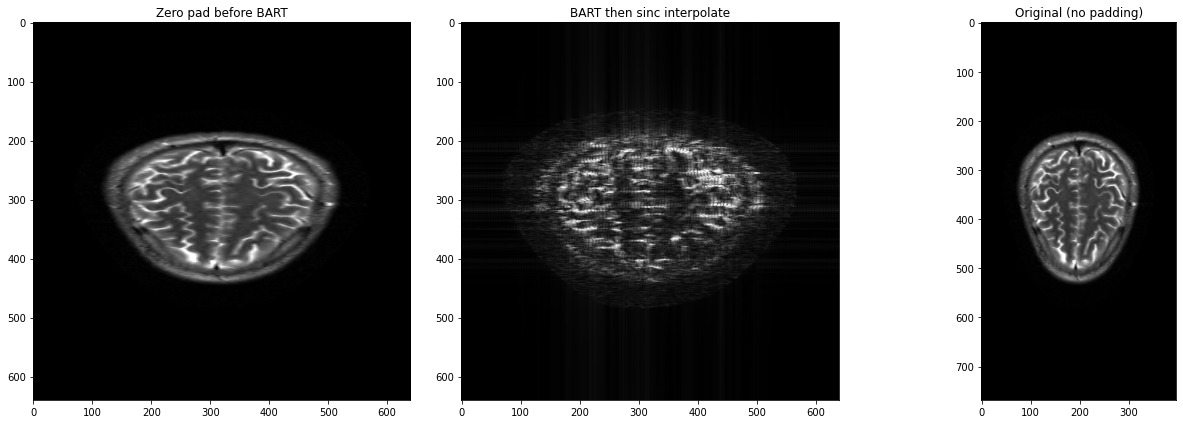

In [51]:
# Plot all three methods for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Zero pad before BART", "BART then sinc interpolate", "Original (no padding)"]

axs[0].imshow(cs_result_method1, cmap='gray')
axs[0].set_title(titles[0])

axs[1].imshow(cs_result_method2, cmap='gray')
axs[1].set_title(titles[1])

axs[2].imshow(cs_result_method3, cmap='gray')
axs[2].set_title(titles[2])

plt.tight_layout()
plt.show()

# !!plots are wrong, need to account for real matrices before zero-padding to not get a stretched image!

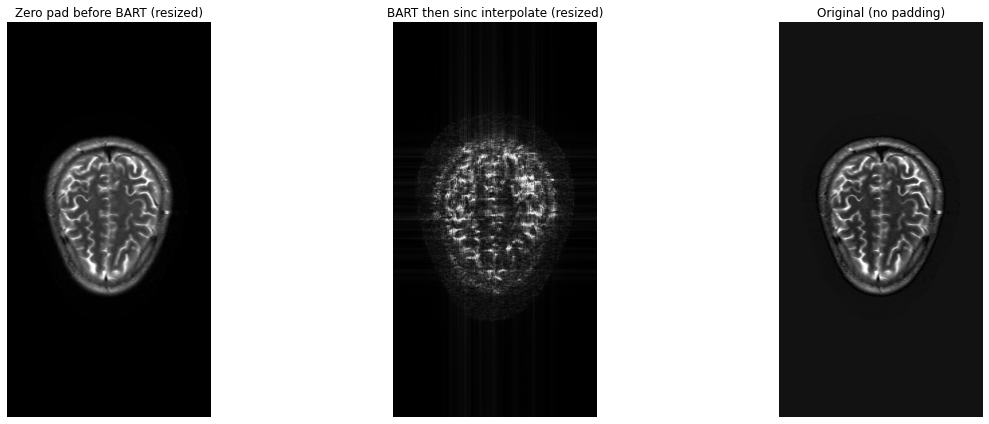

Mean absolute difference between method1 and original: 0.01818970963358879
Max absolute difference between method1 and original: 1.1057727336883545
Mean absolute difference between method2 and original: 0.29889124631881714
Max absolute difference between method2 and original: 6.065159797668457


In [52]:
# Alternative approach: Resize high-res images to match original dimensions
from skimage.transform import resize

# Plot all three methods for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Zero pad before BART", "BART then sinc interpolate", "Original (no padding)"]

# Resize high-res images to match original dimensions
cs_result_method1_resized = resize(cs_result_method1, cs_result_method3.shape, 
                                  anti_aliasing=True, preserve_range=True)
cs_result_method2_resized = resize(cs_result_method2, cs_result_method3.shape, 
                                  anti_aliasing=True, preserve_range=True)

axs[0].imshow(cs_result_method1_resized, cmap='gray')
axs[0].set_title(titles[0] + " (resized)")

axs[1].imshow(cs_result_method2_resized, cmap='gray')
axs[1].set_title(titles[1] + " (resized)")

axs[2].imshow(np.abs(cs_result_method3), cmap='gray')
axs[2].set_title(titles[2])

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# compute difference between the results to check if they're equivalent
diff1 = np.abs(cs_result_method1_resized - cs_result_method3)
diff2 = np.abs(cs_result_method2_resized - cs_result_method3)
print(f"Mean absolute difference between method1 and original: {np.mean(diff1)}") 
print(f"Max absolute difference between method1 and original: {np.max(diff1)}")
print(f"Mean absolute difference between method2 and original: {np.mean(diff2)}")
print(f"Max absolute difference between method2 and original: {np.max(diff2)}")

Use Structural Similarity Index (SSIM)

In [53]:
### copied code from evaluate.py (has function for ssim)
from skimage.metrics import structural_similarity
from typing import Optional

def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]

# Ensure the results are 3D by adding a dummy dimension
img1 = cs_result_method1_resized[np.newaxis, ...]  # Shape (1, H, W)
img2 = cs_result_method2_resized[np.newaxis, ...]  # Shape (1, H, W)
img_ref = cs_result_method3[np.newaxis, ...]  # Shape (1, H, W)

# Compute SSIM using your function
ssim1 = ssim(img_ref, img1)
ssim2 = ssim(img_ref, img2)

print(f"SSIM between Method 1 and Original: {ssim1[0]:.4f}")
print(f"SSIM between Method 2 and Original: {ssim2[0]:.4f}")


SSIM between Method 1 and Original: 0.9920
SSIM between Method 2 and Original: 0.6643


In [54]:
from skimage.metrics import structural_similarity as ssim

ssim1 = ssim((cs_result_method1_resized), (cs_result_method3), 
             data_range=(cs_result_method3).max())

ssim2 = ssim((cs_result_method2_resized), (cs_result_method3), 
             data_range=(cs_result_method3).max())

print(f"SSIM between Method 1 and Original: {ssim1:.4f}")
print(f"SSIM between Method 2 and Original: {ssim2:.4f}")


SSIM between Method 1 and Original: 0.9920
SSIM between Method 2 and Original: 0.6643


### Improved Ways to visually Compare the Methods

#### Visualizing Absolute Difference Maps (Best for Identifying Artifacts)

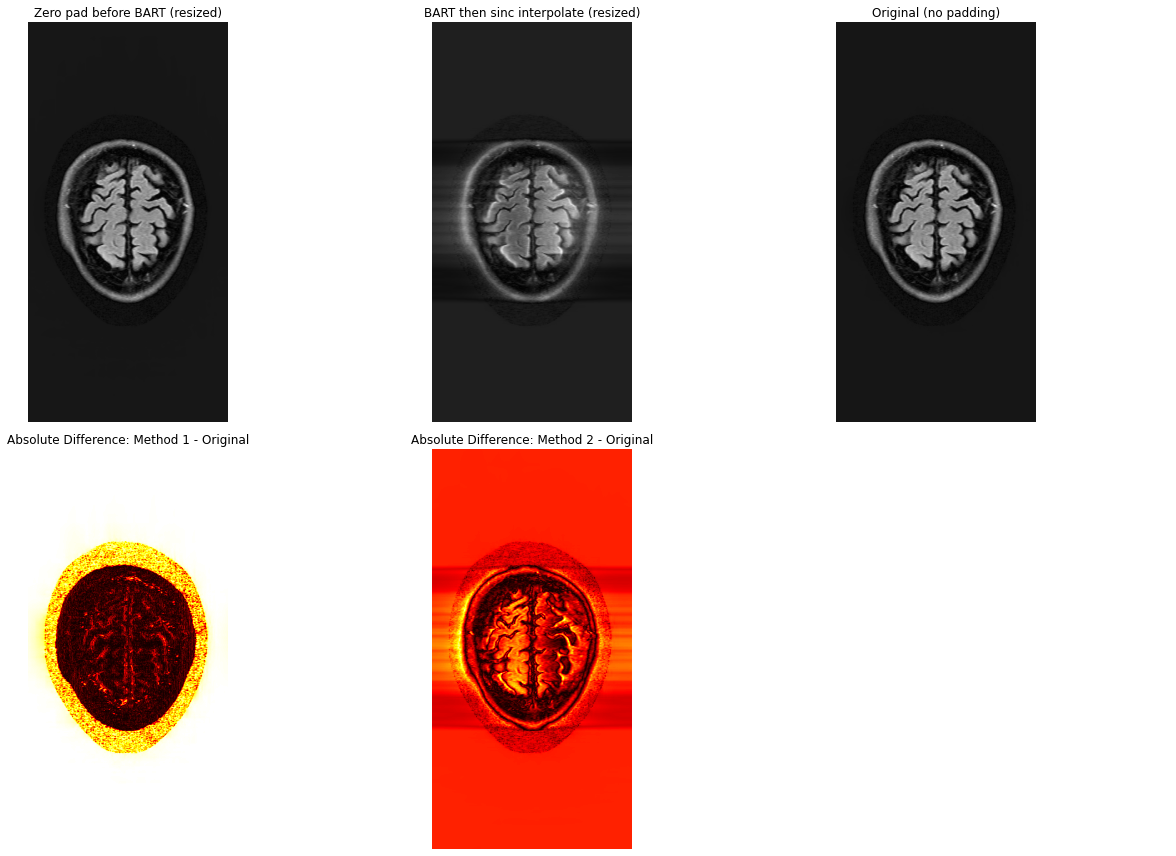

In [102]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

titles = [
    "Zero pad before BART (resized)", 
    "BART then sinc interpolate (resized)", 
    "Original (no padding)",
    "Absolute Difference: Method 1 - Original",
    "Absolute Difference: Method 2 - Original"
]

# First row: reconstructed images
axs[0, 0].imshow(cs_result_method1_resized, cmap='gray')
axs[0, 0].set_title(titles[0])

axs[0, 1].imshow(cs_result_method2_resized, cmap='gray')
axs[0, 1].set_title(titles[1])

axs[0, 2].imshow(np.abs(cs_result_method3), cmap='gray')
axs[0, 2].set_title(titles[2])

# Compute absolute difference
diff1 = np.abs(cs_result_method1_resized - cs_result_method3)
diff2 = np.abs(cs_result_method2_resized - cs_result_method3)

# Second row: absolute difference maps
axs[1, 0].imshow(diff1, cmap='hot')
axs[1, 0].set_title(titles[3])

axs[1, 1].imshow(diff2, cmap='hot')
axs[1, 1].set_title(titles[4])

axs[1, 2].axis("off")  # Leave one plot blank

# Hide axes
for ax in axs.flatten():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

#### Are the differences intensity related? => need normalization or histogram matching to make the intensity distributions comparable

##### Histogram matching

Method 1 - Min: 0.001513, Max: 5.199852
Method 2 - Min: 0.011390, Max: 4.466312
Original - Min: 0.000008, Max: 5.354820


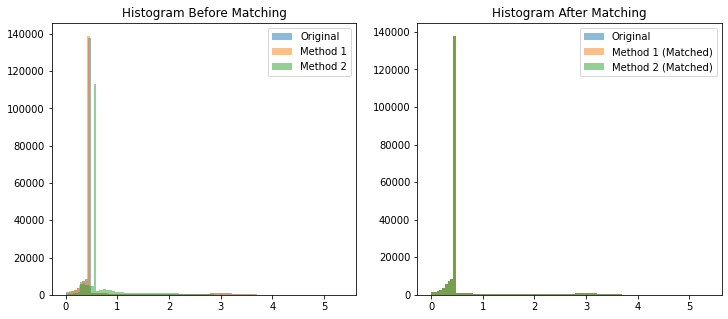

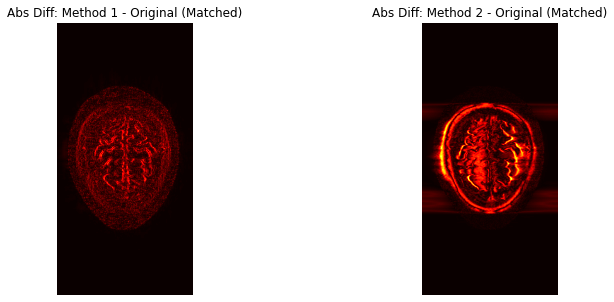

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

# Ensure images are non-zero
method1_real = np.abs(cs_result_method1_resized)
method2_real = np.abs(cs_result_method2_resized)
original_real = np.abs(cs_result_method3)

# Check for minimum and maximum values
print(f"Method 1 - Min: {method1_real.min():.6f}, Max: {method1_real.max():.6f}")
print(f"Method 2 - Min: {method2_real.min():.6f}, Max: {method2_real.max():.6f}")
print(f"Original - Min: {original_real.min():.6f}, Max: {original_real.max():.6f}")

# Apply histogram matching
method1_matched = match_histograms(method1_real, original_real)
method2_matched = match_histograms(method2_real, original_real)

# Compute absolute difference after histogram matching
abs_diff1 = np.abs(method1_matched - original_real)
abs_diff2 = np.abs(method2_matched - original_real)

# Plot histograms before and after matching
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(original_real.ravel(), bins=100, alpha=0.5, label="Original")
plt.hist(method1_real.ravel(), bins=100, alpha=0.5, label="Method 1")
plt.hist(method2_real.ravel(), bins=100, alpha=0.5, label="Method 2")
plt.legend()
plt.title("Histogram Before Matching")

plt.subplot(1, 2, 2)
plt.hist(original_real.ravel(), bins=100, alpha=0.5, label="Original")
plt.hist(method1_matched.ravel(), bins=100, alpha=0.5, label="Method 1 (Matched)")
plt.hist(method2_matched.ravel(), bins=100, alpha=0.5, label="Method 2 (Matched)")
plt.legend()
plt.title("Histogram After Matching")

plt.show()

# Plot absolute difference images
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(abs_diff1, cmap="hot")
axs[0].set_title("Abs Diff: Method 1 - Original (Matched)")
axs[1].imshow(abs_diff2, cmap="hot")
axs[1].set_title("Abs Diff: Method 2 - Original (Matched)")

for ax in axs:
    ax.set_axis_off()

plt.show()


In [104]:
from skimage.metrics import structural_similarity as ssim

ssim1 = ssim(np.abs(method1_matched), np.abs(cs_result_method3), 
             data_range=np.abs(cs_result_method3).max() - np.abs(cs_result_method3).min())

ssim2 = ssim(np.abs(method2_matched), np.abs(cs_result_method3), 
             data_range=np.abs(cs_result_method3).max() - np.abs(cs_result_method3).min())

print(f"SSIM between Method 1 and Original: {ssim1:.4f}")
print(f"SSIM between Method 2 and Original: {ssim2:.4f}")

SSIM between Method 1 and Original: 0.9864
SSIM between Method 2 and Original: 0.8628


##### Min max normalization

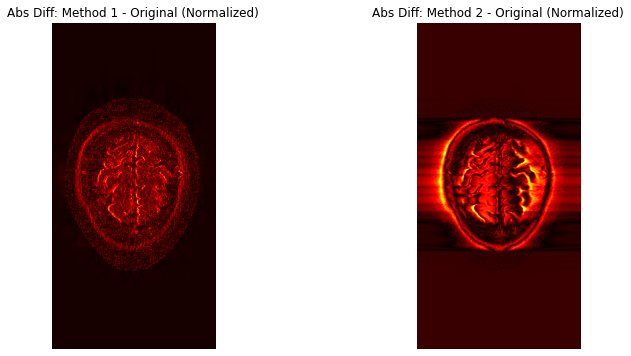

Method 1 - Mean: 0.006072, Std: 0.008737
Method 2 - Mean: 0.057904, Std: 0.056615


In [105]:
def min_max_normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Apply normalization to all images
original_norm = min_max_normalize(original_real)
method1_norm = min_max_normalize(method1_real)
method2_norm = min_max_normalize(method2_real)

# Compute absolute differences after normalization
diff1_norm = np.abs(method1_norm - original_norm)
diff2_norm = np.abs(method2_norm - original_norm)

# Display normalized absolute difference maps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(diff1_norm, cmap='hot')
axs[0].set_title("Abs Diff: Method 1 - Original (Normalized)")

axs[1].imshow(diff2_norm, cmap='hot')
axs[1].set_title("Abs Diff: Method 2 - Original (Normalized)")
for ax in axs:
    ax.set_axis_off()

plt.show()

# Compute new statistics
print(f"Method 1 - Mean: {np.mean(diff1_norm):.6f}, Std: {np.std(diff1_norm):.6f}")
print(f"Method 2 - Mean: {np.mean(diff2_norm):.6f}, Std: {np.std(diff2_norm):.6f}")


In [106]:
from skimage.metrics import structural_similarity as ssim

ssim_method1 = ssim(original_norm, method1_norm, data_range=1)
ssim_method2 = ssim(original_norm, method2_norm, data_range=1)

print(f"SSIM Method 1 vs Original: {ssim_method1:.6f}")
print(f"SSIM Method 2 vs Original: {ssim_method2:.6f}")


SSIM Method 1 vs Original: 0.986031
SSIM Method 2 vs Original: 0.824651


## Test for GPU usage bart (not possible)

Select a file

In [4]:
# Select a file and save in hf
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')

In [5]:
# Get k-space
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))

Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


Shape kspace = (number of slices, number of coils, height, width)

In [6]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual CS undersampling pattern for the actual reconstruction pipeline itself

## Create ACS masked space for S_i
from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!

print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))

Shape of the generated mask:  torch.Size([1, 1, 1, 320, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [7]:
## create real world CS undersampling 
# SELECT ACCELERATION FACTOR
R = 4

# get Real-life CS mask data
import scipy.io as sio
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

mask = generate_array(kspace.shape, R, mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0

PERFORM BART reconstructions with zero-padded k-space (before and after )

In [15]:
import bart
print(bart.bart(1, "version -g"))

Exception: Command exited with an error.

In [14]:
import bart
import numpy as np
import time

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)

    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -g'.format(lamda, num_iter), kspace_perm, S_perm)
        # -S = rescale image after reconstrucition
        # -l1 = l1 wavelet (other option is l2 regularization)
        # -r lambda = regularization parameter
        # -i iter = max number of iterations
    return reconstruction

middle_slice_idx = kspace.shape[0] // 2
# Method 3: Original reconstruction (no zero padding)
print("\nMethod 3: Original reconstruction (no zero padding)")
start_time = time.time()

# Get the middle slice (same as before)
middle_slice_kspace = masked_kspace[middle_slice_idx, :, :, :]
middle_slice_kspace_ACS = masked_kspace_ACS[middle_slice_idx, :, :, :]

# Estimate sensitivity maps and perform CS directly on original data
S_original = estimate_sensitivity_maps(middle_slice_kspace_ACS)
cs_result_method3 = CS(middle_slice_kspace, S_original)

method3_time = time.time() - start_time
print(f"Method 3 execution time: {method3_time:.4f} seconds")
print(f"Method 3 output shape: {cs_result_method3.shape}")


Method 3: Original reconstruction (no zero padding)


Exception: Command exited with an error.

## Test BART for all slices together: (worse!)

In [ ]:
# Select a file and save in hf
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')

# Get k-space
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print(kspace.shape)
# shape (num_slices, num_coils, rows, cols)

(16, 20, 640, 320)


In [124]:
# First, we need to create 2 masked versions of k-space:
#   - We need to estimate our sensitivity maps as if we have undersampled data with an ACS region (using ESPIRiT)
#   - We need an actual CS undersampling pattern for the actual reconstruction pipeline itself

## Create ACS masked space for S_i
from fastmri.data.subsample import EquispacedMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func) # For validation data we should pass a seed though!

print("Shape of the generated mask: ", str(mask_ACS.shape))
print("Datatype of the generated mask: ", str(type(mask_ACS)))

Shape of the generated mask:  torch.Size([1, 1, 1, 320, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [125]:
## create real world CS undersampling 
# SELECT ACCELERATION FACTOR
R = 4

# get Real-life CS mask data
import scipy.io as sio
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

mask = generate_array(kspace.shape, R, mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0

estimating S for all 16 slices at once = 11min20 (20 threads = 5min)

In [126]:
import bart
# BART expects: (rows, cols, slices, coils)
# Move axes to BART format: 
masked_kspace_ACS_bart = np.transpose(masked_kspace_ACS, (2, 3, 0, 1))
print(masked_kspace_ACS_bart.shape)

S_bart = bart.bart(1, "ecalib -d0 -m1", masked_kspace_ACS_bart)
print(S_bart.shape)

S = np.transpose(S_bart, (2, 3, 0, 1))
print(S.shape)


(640, 320, 16, 20)
(640, 320, 16, 20)
(16, 20, 640, 320)


CS giving entire batch to bart: 3min44  (20 threads = 36s)

In [127]:
def CS_batch(kspace, S, lamda=0.005, num_iter=50):
    """
    Perform batch CS reconstruction using BART.
    Input shapes: (num_slices, num_coils, rows, cols)
    """  
    # kspace and S must match shape (slices, coils, rows, cols)"
    assert kspace.shape == S.shape 
    
    # BART expects: (rows, cols, slices, coils)
    # Move axes to BART format: 
    kspace_bart = np.transpose(kspace, (2, 3, 0, 1))
    S_bart = np.transpose(S, (2, 3, 0, 1))
 
    # Run batch reconstruction
    recon = bart.bart(1, f'pics -S -l1 -r {lamda} -i {num_iter} -d 0', kspace_bart, S_bart)

     # Output is (rows, cols, 1, slices) → squeeze and reorder
    recon = np.squeeze(recon)
    recon = np.transpose(recon, (2, 0, 1))  # -> (slices, rows, cols)

    return recon

recon_batch = CS_batch(masked_kspace, S, lamda=0.005, num_iter=50)

In [128]:
print(recon_batch.shape)
print(recon_batch[0].shape)

(16, 640, 320)
(640, 320)


estimate S for 1 slice = 10 sec (20 threads = 2s)

In [129]:
def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

# select slice
middle_slice_idx = kspace.shape[0] // 2
# Get the middle slice  
middle_slice_kspace = masked_kspace_ACS[middle_slice_idx, :, :, :]

S_1slice = estimate_sensitivity_maps(middle_slice_kspace)
print(S_1slice.shape)



(20, 640, 320)


estimate S for all slices, slice per slice 2m 44  (20 threds: 35s)

In [130]:
import numpy as np
S_slice = np.zeros_like(S, dtype=np.complex64)

for i in range(kspace.shape[0]):
    slice_masked_kspace_ACS = masked_kspace_ACS[i, :, :, :]
    S_slice[i] = estimate_sensitivity_maps(slice_masked_kspace_ACS)


CS done slice per slice 2m 49sec  (20 threads: 26s)

In [131]:
def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -d 0'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

recon_slice = np.zeros((kspace.shape[0], kspace.shape[2], kspace.shape[3]), dtype=np.complex64)

for i in range(kspace.shape[0]):
    # INDIVIDUAL sensitivity map
    S_i = S_slice[i,:,:,:]
    recon_slice[i] = CS(masked_kspace[i], S_i)

CS done slice per slice, 

but only using the middle coil sensitivities instead of all seperate ones

3 min (26s)

In [132]:
# select slice
middle_slice_idx = kspace.shape[0] // 2
# Get the middle slice  
middle_slice_kspace = masked_kspace_ACS[middle_slice_idx, :, :, :]
S_middle = estimate_sensitivity_maps(middle_slice_kspace)

In [133]:


recon_middle_S = np.zeros((kspace.shape[0], kspace.shape[2], kspace.shape[3]), dtype=np.complex64)
for i in range(kspace.shape[0]):

    # MIDDLE sensitivity map for all
    recon_middle_S[i] = CS(masked_kspace[i], S_middle)

### visualize results

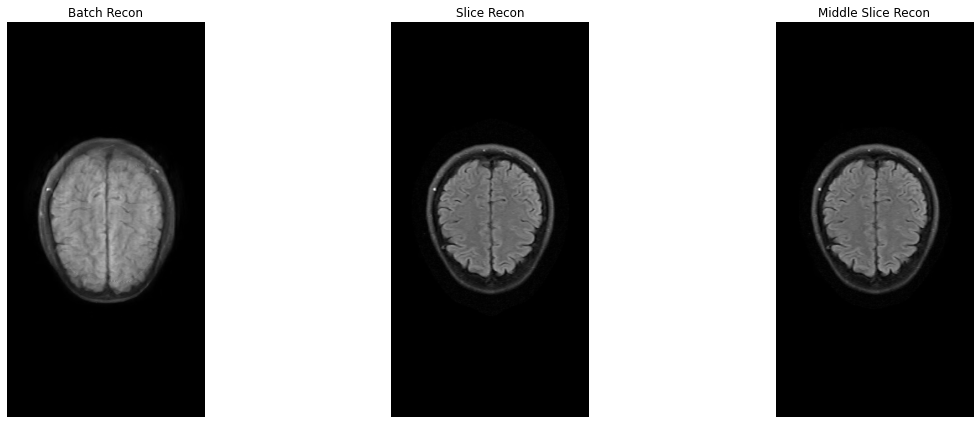

In [134]:
number_slice = 7
# Plot all three methods for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Batch Recon", "Slice Recon", "Middle Slice Recon"]

axs[0].imshow(np.abs(recon_batch[number_slice]), cmap='gray')
axs[0].set_title(titles[0])

axs[1].imshow(np.abs(recon_slice[number_slice]), cmap='gray')
axs[1].set_title(titles[1])

axs[2].imshow(np.abs(recon_middle_S[number_slice]), cmap='gray')
axs[2].set_title(titles[2])
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()
plt.show()


conclude: per batch = worse + takes longer

## Test parallel processing of files => BEST = as much workers as possibles in parallel

In [15]:
import os
os.environ["OMP_NUM_THREADS"] = "2"  # or 2 if you have many processes
import h5py
import numpy as np
from pathlib import Path
from fastmri.data import transforms as T
from fastmri.data.subsample import EquispacedMaskFunc
import torch
import time
import gc
import random

import scipy.io as sio
import logging
from multiprocessing import Pool, cpu_count

## CONSTANTS
# Directory containing HDF5 files
INPUT_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train"
files = list(Path(INPUT_DIR).glob("**/*.h5")) # Get all HDF5 files in the input directory
file_count = 1
OUTPUT_DIR = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test"
os.makedirs(OUTPUT_DIR, exist_ok=True) # Ensure output directory exists
TARGET_SIZE = (640, 640)
# matlab file with CS sampling profiles
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')

def fifty_fifty():
    '''
    Return True with a probability of 0.5, otherwise False
    '''
    return random.random() < .5

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    # Convert masked k-space from Torch tensor back to numpy array
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

def generate_array(shape, R, mat_file, tensor_out):
    '''
    Generate CS mask for given k_space shape and acceleration factor R
    Args:
        shape (tuple): Shape of the k-space data
        R (int): Acceleration factor
        mat_file: matlab file containing the CS masks
        tensor_out (bool): If True, the output will be a torch tensor
    Returns:
        array (numpy.array or torch.tensor): CS mask 
    '''
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]

    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    import bart  # Make sure this is imported AFTER setting the env var
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def zero_pad_kspace(kspace, target_size):
    """
    Zero-pad k-space to achieve sinc interpolation in image domain
    
    Args:
        kspace (numpy.array): K-space data (can be 2D or 3D with num_coils)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        kspace_padded (numpy.array): Zero-padded k-space
    """
    is_3d = len(kspace.shape) == 3  # Check if num_coils dimension exists
    if not is_3d:
        kspace = kspace[np.newaxis, ...]  # Add dummy coil dimension

    rows, cols = kspace.shape[-2], kspace.shape[-1]
    target_rows, target_cols = target_size

    # Convert k-space to fastMRI expected format (real, imag) -> shape (num_coils, rows, cols, 2)
    kspace_tensor = T.to_tensor(kspace)

     # Handle cropping if the size is too large
    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows = target_rows
        cols = target_cols

     # if only 1 dimension is too large, crop that dimension   
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    # Handle zero-padding if the size is too small
    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        
        # Apply zero padding to 3D array
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor)
    return kspace_padded if is_3d else kspace_padded[0]  # Remove dummy coil dimension if needed

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    import bart  # Make sure this is imported AFTER setting the env var
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -d 0'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

def process_file(file_index_tuple):
    # Set the number of threads BEFORE ANYTHING ELSE
    #os.environ["OMP_NUM_THREADS"] = "4"  # use 4 threads per process

    file_count, file = file_index_tuple  # UNPACK HERE

    print(f"Processing ({file_count}) {file.name} with PID {os.getpid()}")
    
    # Timer for the entire file
    start_time_file = time.time()   

    # Open HDF5 file in read mode
    with h5py.File(file, 'r') as hf:
        kspace = hf['kspace'][()]

    # Randomly decide if R = 4 or 8 for equispaced mask => ACS region for estimating coil sensitivities! 
    undersampling_bool = fifty_fifty()  
    if undersampling_bool:
        mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
    else:
        mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])
    masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func)
    #print("Shape of the generated ACS mask: ", str(mask_ACS.shape))

    # same random if R = 4 or 8 for CS mask
    if undersampling_bool:
        mask = generate_array(kspace.shape, 4, mat_file, tensor_out=False)
    else:
        mask = generate_array(kspace.shape, 8, mat_file, tensor_out=False)
    # (following = OK, see Transforms.apply_mask)
    masked_kspace = kspace * mask + 0.0   # +0.0 removes the sign of the zeros
    #print("Shape of the generated CS mask: ", str(mask.shape))


    ##################### CHANGED: SO WORKS WITH zero-padding/cropping BEFORE BART ############
    # Perform CS reconstruction
    cs_data = np.zeros((kspace.shape[0], TARGET_SIZE[0], TARGET_SIZE[1]), dtype=np.complex64)
    for slice in range(kspace.shape[0]):
        # timer for each slice
        start_time_slice = time.time()

        # Zero-fill/crop before ESPIRiT sensitivity estimation
        padded_kspace_ACS = zero_pad_kspace(masked_kspace_ACS[slice, :, :, :], TARGET_SIZE)
        padded_kspace = zero_pad_kspace(masked_kspace[slice, :, :, :], TARGET_SIZE)
        #print("Shape of the padded kspace: ", str(np.shape(padded_kspace)))

        # Estimate sensitivity maps
        S_padded = estimate_sensitivity_maps(padded_kspace_ACS) # estimate Si with ACS region

        # Perform CS reconstruction with zero-filled k-space
        cs_data[slice, :, :] = CS(padded_kspace, S_padded)
        end_time_slice = time.time()
        elapsed_time_slice = end_time_slice - start_time_slice
        print(f"Time for slice of {file.name}: {elapsed_time_slice:.4f} seconds")
    #print("Shape of the numpy-converted CS data: ", str(cs_data.shape))

    # Save file to given output DIR 
    ## stem attribute gives the base name of the file without the extension. 
    # For example: If your input file is named sample_data.h5, file.stem will return sample_data
    output_file = os.path.join(OUTPUT_DIR, file.stem + "_cs.npy")
    np.save(output_file, cs_data)

    # Free up memory and go to next file
    time.sleep(1) 
    del kspace, masked_kspace, mask, cs_data    # Delete the variables to free up memory
    time.sleep(1)
    gc.collect()    # Collect garbage to free up memory

    # Timer for the entire file: calculate and print total elapsed time after all slices
    end_time_file = time.time()
    elapsed_time_file = end_time_file - start_time_file
    print(f"Total time for processing {file.name}: {elapsed_time_file:.4f} seconds")

    return output_file  

def run_parallel(files, max_files=None, num_workers=None):
    if max_files:
        files = files[:max_files]

    num_workers = num_workers or min(cpu_count(), num_workers)  # Don't oversubscribe threads
    print(f"Using {num_workers} parallel workers")

    file_index_tuples = list(enumerate(files, start=1))

    with Pool(processes=num_workers) as pool:
        results = pool.map(process_file, file_index_tuples)

    return results

run_parallel(files, 12, 4)


#! Always set OMP_NUM_THREADS inside the function, not globally 
# — it must be set before the C-libs (like FFTW) are loaded in that process.

Using 4 parallel workers
Processing (2) file_brain_AXT2_209_2090051.h5 with PID 448270Processing (1) file_brain_AXT2_207_2070515.h5 with PID 448269Processing (4) file_brain_AXFLAIR_202_6000472.h5 with PID 448272Processing (3) file_brain_AXT1POST_210_6001620.h5 with PID 448271



Time for slice of file_brain_AXT2_207_2070515.h5: 5.1003 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 4.5063 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 4.9228 seconds
Time for slice of file_brain_AXT2_209_2090051.h5: 16.2635 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 5.2390 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 4.6193 seconds
Time for slice of file_brain_AXT1POST_210_6001620.h5: 22.1979 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 5.1006 seconds
Time for slice of file_brain_AXFLAIR_202_6000472.h5: 28.3850 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 4.9487 seconds
Time for slice of file_brain_AXT2_209_2090051.h5: 16.4031 se

['/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_207_2070515_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_209_2090051_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT1POST_210_6001620_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXFLAIR_202_6000472_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT1PRE_205_6000021_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_210_6001634_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_204_2040058_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_202_2020162_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_210_6001784_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_200_6002587_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/asloc

now did 7min 30 for 4 files with 2 workers

20 min 12 for 12 files with 4 workers (each 2 threads)

23 min 12 for 12 files with 2 workers (each 4 threads)

20 min 30 for 12 files with 8 workers (each 1 thread) => as good as above + amount of files not even ideal for it!

31 min for 12 files with 1 worker (with 8 threads)

In [17]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # or 2 if you have many processes
import h5py
import numpy as np
from pathlib import Path
from fastmri.data import transforms as T
from fastmri.data.subsample import EquispacedMaskFunc
import torch
import time
import gc
import random

import scipy.io as sio
import logging
from multiprocessing import Pool, cpu_count

## CONSTANTS
# Directory containing HDF5 files
INPUT_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train"
files = list(Path(INPUT_DIR).glob("**/*.h5")) # Get all HDF5 files in the input directory
file_count = 1
OUTPUT_DIR = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test"
os.makedirs(OUTPUT_DIR, exist_ok=True) # Ensure output directory exists
TARGET_SIZE = (640, 640)
# matlab file with CS sampling profiles
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')

def fifty_fifty():
    '''
    Return True with a probability of 0.5, otherwise False
    '''
    return random.random() < .5

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    # Convert masked k-space from Torch tensor back to numpy array
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

def generate_array(shape, R, mat_file, tensor_out):
    '''
    Generate CS mask for given k_space shape and acceleration factor R
    Args:
        shape (tuple): Shape of the k-space data
        R (int): Acceleration factor
        mat_file: matlab file containing the CS masks
        tensor_out (bool): If True, the output will be a torch tensor
    Returns:
        array (numpy.array or torch.tensor): CS mask 
    '''
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]

    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    import bart  # Make sure this is imported AFTER setting the env var
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def zero_pad_kspace(kspace, target_size):
    """
    Zero-pad k-space to achieve sinc interpolation in image domain
    
    Args:
        kspace (numpy.array): K-space data (can be 2D or 3D with num_coils)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        kspace_padded (numpy.array): Zero-padded k-space
    """
    is_3d = len(kspace.shape) == 3  # Check if num_coils dimension exists
    if not is_3d:
        kspace = kspace[np.newaxis, ...]  # Add dummy coil dimension

    rows, cols = kspace.shape[-2], kspace.shape[-1]
    target_rows, target_cols = target_size

    # Convert k-space to fastMRI expected format (real, imag) -> shape (num_coils, rows, cols, 2)
    kspace_tensor = T.to_tensor(kspace)

     # Handle cropping if the size is too large
    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows = target_rows
        cols = target_cols

     # if only 1 dimension is too large, crop that dimension   
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    # Handle zero-padding if the size is too small
    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        
        # Apply zero padding to 3D array
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor)
    return kspace_padded if is_3d else kspace_padded[0]  # Remove dummy coil dimension if needed

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    import bart  # Make sure this is imported AFTER setting the env var
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -d 0'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

def process_file(file_index_tuple):
    # Set the number of threads BEFORE ANYTHING ELSE
    #os.environ["OMP_NUM_THREADS"] = "4"  # use 4 threads per process

    file_count, file = file_index_tuple  # UNPACK HERE

    print(f"Processing ({file_count}) {file.name} with PID {os.getpid()}")
    
    # Timer for the entire file
    start_time_file = time.time()   

    # Open HDF5 file in read mode
    with h5py.File(file, 'r') as hf:
        kspace = hf['kspace'][()]

    # Randomly decide if R = 4 or 8 for equispaced mask => ACS region for estimating coil sensitivities! 
    undersampling_bool = fifty_fifty()  
    if undersampling_bool:
        mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
    else:
        mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])
    masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func)
    #print("Shape of the generated ACS mask: ", str(mask_ACS.shape))

    # same random if R = 4 or 8 for CS mask
    if undersampling_bool:
        mask = generate_array(kspace.shape, 4, mat_file, tensor_out=False)
    else:
        mask = generate_array(kspace.shape, 8, mat_file, tensor_out=False)
    # (following = OK, see Transforms.apply_mask)
    masked_kspace = kspace * mask + 0.0   # +0.0 removes the sign of the zeros
    #print("Shape of the generated CS mask: ", str(mask.shape))


    ##################### CHANGED: SO WORKS WITH zero-padding/cropping BEFORE BART ############
    # Perform CS reconstruction
    cs_data = np.zeros((kspace.shape[0], TARGET_SIZE[0], TARGET_SIZE[1]), dtype=np.complex64)
    for slice in range(kspace.shape[0]):
        # timer for each slice
        start_time_slice = time.time()

        # Zero-fill/crop before ESPIRiT sensitivity estimation
        padded_kspace_ACS = zero_pad_kspace(masked_kspace_ACS[slice, :, :, :], TARGET_SIZE)
        padded_kspace = zero_pad_kspace(masked_kspace[slice, :, :, :], TARGET_SIZE)
        #print("Shape of the padded kspace: ", str(np.shape(padded_kspace)))

        # Estimate sensitivity maps
        S_padded = estimate_sensitivity_maps(padded_kspace_ACS) # estimate Si with ACS region

        # Perform CS reconstruction with zero-filled k-space
        cs_data[slice, :, :] = CS(padded_kspace, S_padded)
        end_time_slice = time.time()
        elapsed_time_slice = end_time_slice - start_time_slice
        print(f"Time for slice of {file.name}: {elapsed_time_slice:.4f} seconds")
    #print("Shape of the numpy-converted CS data: ", str(cs_data.shape))

    # Save file to given output DIR 
    ## stem attribute gives the base name of the file without the extension. 
    # For example: If your input file is named sample_data.h5, file.stem will return sample_data
    output_file = os.path.join(OUTPUT_DIR, file.stem + "_cs.npy")
    np.save(output_file, cs_data)

    # Free up memory and go to next file
    time.sleep(1) 
    del kspace, masked_kspace, mask, cs_data    # Delete the variables to free up memory
    time.sleep(1)
    gc.collect()    # Collect garbage to free up memory

    # Timer for the entire file: calculate and print total elapsed time after all slices
    end_time_file = time.time()
    elapsed_time_file = end_time_file - start_time_file
    print(f"Total time for processing {file.name}: {elapsed_time_file:.4f} seconds")

    return output_file  

def run_parallel(files, max_files=None, num_workers=None):
    if max_files:
        files = files[:max_files]

    num_workers = num_workers or min(cpu_count(), num_workers)  # Don't oversubscribe threads
    print(f"Using {num_workers} parallel workers")

    file_index_tuples = list(enumerate(files, start=1))

    with Pool(processes=num_workers) as pool:
        results = pool.map(process_file, file_index_tuples)

    return results

run_parallel(files, 12, 8)


#! Always set OMP_NUM_THREADS inside the function, not globally 
# — it must be set before the C-libs (like FFTW) are loaded in that process.

Using 8 parallel workers


Processing (3) file_brain_AXT1POST_210_6001620.h5 with PID 550619Processing (2) file_brain_AXT2_209_2090051.h5 with PID 550618Processing (1) file_brain_AXT2_207_2070515.h5 with PID 550617Processing (4) file_brain_AXFLAIR_202_6000472.h5 with PID 550620Processing (5) file_brain_AXT1PRE_205_6000021.h5 with PID 550621Processing (6) file_brain_AXT2_210_6001634.h5 with PID 550622Processing (7) file_brain_AXT2_204_2040058.h5 with PID 550623Processing (8) file_brain_AXT2_202_2020162.h5 with PID 550624







Time for slice of file_brain_AXT2_207_2070515.h5: 8.8026 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 9.2710 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 9.0028 seconds
Time for slice of file_brain_AXT2_209_2090051.h5: 28.6040 seconds
Time for slice of file_brain_AXT2_207_2070515.h5: 9.1519 seconds
Time for slice of file_brain_AXT1PRE_205_6000021.h5: 38.1827 seconds
Time for slice of file_brain_AXT2_202_2020162.h5: 37.7611 seconds
Time for slice of file_brain_AXT1

['/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_207_2070515_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_209_2090051_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT1POST_210_6001620_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXFLAIR_202_6000472_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT1PRE_205_6000021_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_210_6001634_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_204_2040058_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_202_2020162_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_210_6001784_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test/file_brain_AXT2_200_6002587_cs.npy',
 '/DATASERVER/MIC/GENERAL/STUDENTS/asloc

In [18]:
import h5py
import numpy as np
from pathlib import Path
from fastmri.data import transforms as T
from fastmri.data.subsample import EquispacedMaskFunc
import torch
import time
import gc
import bart
import scipy.io as sio
import random
import os
import logging

logging.basicConfig(filename='processingBRAIN.log', level=logging.INFO)
logging.info('Started processing')

# Set number of CPU threads to 20
os.environ["OMP_NUM_THREADS"] = "8"

# matlab file with CS sampling profiles
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')

# Directory containing HDF5 files
INPUT_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_train"

# Get all HDF5 files in the input directory
files = list(Path(INPUT_DIR).glob("**/*.h5"))
file_count = 1

# Output directory for CS data
OUTPUT_DIR = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/CS_Output/test2"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def fifty_fifty():
    '''
    Return True with a probability of 0.5, otherwise False
    '''
    return random.random() < .5

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
    # Convert masked k-space from Torch tensor back to numpy array
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

def generate_array(shape, R, mat_file, tensor_out):
    '''
    Generate CS mask for given k_space shape and acceleration factor R
    Args:
        shape (tuple): Shape of the k-space data
        R (int): Acceleration factor
        mat_file: matlab file containing the CS masks
        tensor_out (bool): If True, the output will be a torch tensor
    Returns:
        array (numpy.array or torch.tensor): CS mask 
    '''
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]

    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def zero_pad_kspace(kspace, target_size):
    """
    Zero-pad k-space to achieve sinc interpolation in image domain
    
    Args:
        kspace (numpy.array): K-space data (can be 2D or 3D with num_coils)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        kspace_padded (numpy.array): Zero-padded k-space
    """
    is_3d = len(kspace.shape) == 3  # Check if num_coils dimension exists
    if not is_3d:
        kspace = kspace[np.newaxis, ...]  # Add dummy coil dimension

    rows, cols = kspace.shape[-2], kspace.shape[-1]
    target_rows, target_cols = target_size

    # Convert k-space to fastMRI expected format (real, imag) -> shape (num_coils, rows, cols, 2)
    kspace_tensor = T.to_tensor(kspace)

     # Handle cropping if the size is too large
    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows = target_rows
        cols = target_cols

     # if only 1 dimension is too large, crop that dimension   
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    # Handle zero-padding if the size is too small
    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        
        # Apply zero padding to 3D array
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor)
    return kspace_padded if is_3d else kspace_padded[0]  # Remove dummy coil dimension if needed

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -d 0'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

for file in files:
    # print(str(file_count)+". Starting to process file "+str(file)+'...')
    logging.info(f"{file_count}. Starting to process file {file}...")

    # Timer for the entire file
    start_time_file = time.time()   

    # Open HDF5 file in read mode
    with h5py.File(file, 'r') as hf:
        kspace = hf['kspace'][()]

    #print("Shape of the raw kspace: ", str(np.shape(kspace)))

    # Define target resolution for zero-padding/cropping
    target_size = (640, 640)  # Modify if needed

    # Randomly decide if R = 4 or 8 for equispaced mask => ACS region for estimating coil sensitivities! 
    undersampling_bool = fifty_fifty()  
    if undersampling_bool:
        mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
    else:
        mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])
    masked_kspace_ACS, mask_ACS = apply_mask(kspace, mask_func)
    #print("Shape of the generated ACS mask: ", str(mask_ACS.shape))

    # same random if R = 4 or 8 for CS mask
    if undersampling_bool:
        mask = generate_array(kspace.shape, 4, mat_file, tensor_out=False)
    else:
        mask = generate_array(kspace.shape, 8, mat_file, tensor_out=False)
    # (following = OK, see Transforms.apply_mask)
    masked_kspace = kspace * mask + 0.0   # +0.0 removes the sign of the zeros
    #print("Shape of the generated CS mask: ", str(mask.shape))


    ##################### CHANGED: SO WORKS WITH zero-padding/cropping BEFORE BART ############
    # Perform CS reconstruction
    cs_data = np.zeros((kspace.shape[0], target_size[0], target_size[1]), dtype=np.complex64)
    for slice in range(kspace.shape[0]):
        # timer for each slice
        start_time_slice = time.time()

        # Zero-fill/crop before ESPIRiT sensitivity estimation
        padded_kspace_ACS = zero_pad_kspace(masked_kspace_ACS[slice, :, :, :], target_size)
        padded_kspace = zero_pad_kspace(masked_kspace[slice, :, :, :], target_size)
        #print("Shape of the padded kspace: ", str(np.shape(padded_kspace)))

         # Estimate sensitivity maps
        S_padded = estimate_sensitivity_maps(padded_kspace_ACS) # estimate Si with ACS region

        # Perform CS reconstruction with zero-filled k-space
        cs_data[slice, :, :] = CS(padded_kspace, S_padded)
        end_time_slice = time.time()
        elapsed_time_slice = end_time_slice - start_time_slice
        #print(f"Time for slice: {elapsed_time_slice:.4f} seconds")
    #print("Shape of the numpy-converted CS data: ", str(cs_data.shape))

    # Save file to given output DIR 
    ## stem attribute gives the base name of the file without the extension. 
    # For example: If your input file is named sample_data.h5, file.stem will return sample_data
    output_file = os.path.join(OUTPUT_DIR, file.stem + "_cs.npy")
    np.save(output_file, cs_data)

    # Free up memory and go to next file
    time.sleep(1) 
    del kspace, masked_kspace, mask, cs_data    # Delete the variables to free up memory
    time.sleep(1)
    gc.collect()    # Collect garbage to free up memory
    file_count += 1
    #print(f"  Saved CS data to {output_file}")
    logging.info(f"  Saved CS data to {output_file}")


    # Timer for the entire file: calculate and print total elapsed time after all slices
    end_time_file = time.time()
    elapsed_time_file = end_time_file - start_time_file
    #print(f"Total time for processing the entire file: {elapsed_time_file:.4f} seconds")
    logging.info(f"Total time for processing the entire file: {elapsed_time_file:.4f} seconds")
    if file_count >= 13:
        break



8 min 50 for 8 threads and only 1 worker (all sequential)

### Compare results to reference (per slice S_i)

Don't compare to ground_truth!

<KeysViewHDF5 ['cs_data', 'grappa_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss', 'sense_data']>
(16, 320, 320)
float32


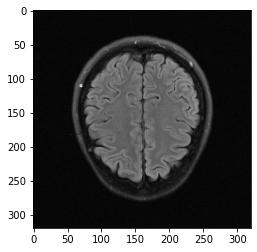

In [80]:
print(hf.keys())
ground_truth = hf['reconstruction_rss'][()]
print(ground_truth.shape)
print(ground_truth.dtype)
plt.imshow(np.abs(ground_truth[7]), cmap='gray')

In [155]:
# before computing metrics => need to both be 320x320 to compare to GT + normalize/AV

import fastmri
from fastmri.data import transforms as T

os.environ["OMP_NUM_THREADS"] = "1"

def preprocess_mri(image, clamp_range=(-6, 6), eps=1e-11):
    """
    Applies AV (absolute value for complex images) and normalizes an MRI image.
    
    Args:
        image (numpy.ndarray or tensor): Input image, possibly complex.
        clamp_range (tuple): Range for clamping values after normalization.
        eps (float): Small epsilon to prevent division by zero in normalization.
    
    Returns:
        (torch.Tensor: Processed image.)
        numpy.ndarray: processed image
    """
    # Convert to tensor if it's a numpy array
    if isinstance(image, np.ndarray):
        image = T.to_tensor(image)

    crop_size = (320, 320)
    # center crop
    image = T.complex_center_crop(image, crop_size)

    # Take absolute value (AV)
    image = fastmri.complex_abs(image)
    
    # Normalize
    image, _, _ = T.normalize_instance(image, eps=eps)
    image = image.clamp(*clamp_range)
    return image.numpy()  #return numpy array instead of tensor


recon_batch_processed = np.zeros((kspace.shape[0], 320, 320))
recon_slice_processed = np.zeros((kspace.shape[0], 320, 320))
recon_middle_S_processed = np.zeros((kspace.shape[0], 320, 320))

for i in range(recon_batch.shape[0]):
    recon_batch_processed[i] = preprocess_mri(recon_batch[i])
    recon_slice_processed[i] = preprocess_mri(recon_slice[i])
    recon_middle_S_processed[i] = preprocess_mri(recon_middle_S[i])


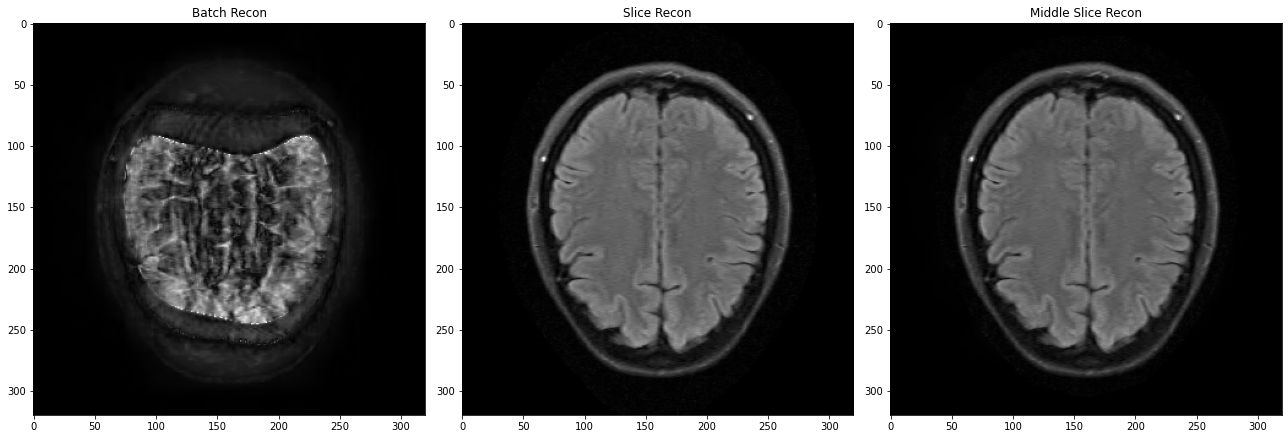

In [157]:
number_slice = 5
# Plot all three methods for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Batch Recon", "Slice Recon", "Middle Slice Recon"]

axs[0].imshow(recon_batch_processed[number_slice], cmap='gray')
axs[0].set_title(titles[0])

axs[1].imshow(recon_slice_processed[number_slice], cmap='gray')
axs[1].set_title(titles[1])

axs[2].imshow(recon_middle_S_processed[number_slice], cmap='gray')
axs[2].set_title(titles[2])
plt.tight_layout()
plt.show()

In [164]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np

def compute_psnr(img1, img2):
    """Computes the PSNR between two images."""
    return psnr(img1, img2, data_range=img1.max())

def compute_ssim(img1, img2):
    """Computes the SSIM between two images."""
    return ssim(img1, img2, data_range=img1.max())

# Assuming you have:
# cs_data_batch: batch reconstruction (slices, rows, cols)
# cs_data_single: single-slice reconstruction for each slice (slices, rows, cols)
# ground_truth: the ground truth for comparison (slices, rows, cols)


# Initialize lists to store PSNR and SSIM values
psnr_batch = []
ssim_batch = []
psnr_single = []
ssim_single = []
psnr_middle = []
ssim_middle = []

ground_truth = recon_slice_processed

# Iterate over each slice
for slice_idx in range(recon_batch.shape[0]):
    # Compare PSNR and SSIM for batch reconstruction
    psnr_batch.append(compute_psnr(ground_truth[slice_idx], (recon_batch_processed[slice_idx])))
    ssim_batch.append(compute_ssim(ground_truth[slice_idx], (recon_batch_processed[slice_idx])))

    # Compare PSNR and SSIM for single-slice reconstruction (assuming each slice in cs_data_single is reconstructed individually)
    psnr_single.append(compute_psnr(ground_truth[slice_idx], (recon_slice_processed[slice_idx])))
    ssim_single.append(compute_ssim(ground_truth[slice_idx], (recon_slice_processed[slice_idx])))

    # Compare PSNR and SSIM for middle-slice reconstruction
    psnr_middle.append(compute_psnr(ground_truth[slice_idx], (recon_middle_S_processed[slice_idx])))
    ssim_middle.append(compute_ssim(ground_truth[slice_idx], (recon_middle_S_processed[slice_idx])))

# Convert to numpy arrays for easier analysis
psnr_batch = np.array(psnr_batch)
ssim_batch = np.array(ssim_batch)
psnr_single = np.array(psnr_single)
ssim_single = np.array(ssim_single)
psnr_middle = np.array(psnr_middle)
ssim_middle = np.array(ssim_middle)

# Print results
print(f"PSNR (Batch): Mean = {psnr_batch.mean():.2f}, Std = {psnr_batch.std():.2f}")
print(f"SSIM (Batch): Mean = {ssim_batch.mean():.2f}, Std = {ssim_batch.std():.2f}")
print(f"PSNR (Single): Mean = {psnr_single.mean():.2f}, Std = {psnr_single.std():.2f}")
print(f"SSIM (Single): Mean = {ssim_single.mean():.2f}, Std = {ssim_single.std():.2f}")
print(f"PSNR (Middle): Mean = {psnr_middle.mean():.2f}, Std = {psnr_middle.std():.2f}")
print(f"SSIM (Middle): Mean = {ssim_middle.mean():.2f}, Std = {ssim_middle.std():.2f}")

PSNR (Batch): Mean = 15.29, Std = 2.19
SSIM (Batch): Mean = 0.49, Std = 0.07
PSNR (Single): Mean = inf, Std = nan
SSIM (Single): Mean = 1.00, Std = 0.00
PSNR (Middle): Mean = inf, Std = nan
SSIM (Middle): Mean = 0.92, Std = 0.08


In [ ]:
print(psnr_middle)
print(ssim_middle)
# YOU CLEARLY SEE, THE FURTHER FROM THE MIDDLE SLICE => THE WORSE THE RECONSTRUCTION

[31.05930986 32.7303191  35.35297759 36.15683038 39.33006877 40.64432528
 44.47580444 45.87799534         inf 44.82147578 39.13062032 36.9517287
 35.06291158 31.57703584 30.16786987 30.82188077]
[0.91190829 0.92483024 0.94517643 0.9514082  0.96935444 0.97307907
 0.98471245 0.98761026 1.         0.98595079 0.96185534 0.94121928
 0.90738501 0.83383558 0.75876456 0.72991742]


In [78]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from typing import Optional

def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]

# Compute PSNR and SSIM for each method
psnr_batch = psnr(ground_truth, recon_batch_cropped)
psnr_slice = psnr(ground_truth, recon_slice_cropped)
psnr_middle = psnr(ground_truth, recon_middle_S_cropped)
ssim_batch = ssim(ground_truth, recon_batch_cropped)
ssim_slice = ssim(ground_truth, recon_slice_cropped)
ssim_middle = ssim(ground_truth, recon_middle_S_cropped)

# Print results
print(f"PSNR (Batch): {psnr_batch:.2f}")
print(f"PSNR (Single): {psnr_slice:.2f}")
print(f"PSNR (Middle): {psnr_middle:.2f}")
print(f"SSIM (Middle)", ssim_batch)
print(f"SSIM (Middle)", ssim_slice)
print(f"SSIM (Middle)", ssim_middle)


/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/conda/envs/DL_MRI_reconstruction_baselines_2/lib/python3.6/site-packages/numpy/core/_methods.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/conda/envs/DL_MRI_reconstruction_baselines_2/lib/python3.6/site-packages/skimage/metrics/_structural_similarity.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  im2 = im2.astype(np.float64)


PSNR (Batch): -67.01
PSNR (Single): -67.38
PSNR (Middle): -67.38
SSIM (Middle) [-3.37148718e-07]
SSIM (Middle) [-2.81437486e-06]
SSIM (Middle) [-2.95564303e-07]


## Here, we can test our preprocessing approach for test data

In [33]:
# R = 8
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
preprocessed_train_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test'
preprocessed_train_path_full = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full'


In [34]:
# First, find out what the value of R is
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!
nPE_mask = hf['mask'][()]
sampled_columns = np.sum(nPE_mask)
R = len(nPE_mask)/sampled_columns
R = float(R)
print(R)


8.0


In [35]:
# Also, use the official test scan ACS region for the sensitivity map estimation
masked_kspace_ACS = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(masked_kspace_ACS)))
print("Datatype of the raw kspace: ", str(type(masked_kspace_ACS)))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


In [36]:
# Now, knowing R, create a CS kspace version from the scan's multicoil_test_full file
def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

hf = h5py.File(os.path.join(preprocessed_train_path_full, file_name), 'r') # Open in read mode!
kspace = hf['kspace'][()]
mask = generate_array(kspace.shape, closer_to_4_or_8(R), mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0


In [ ]:
# Now, let's preform a slice-wise ESPIRiT and CS estimation
cs_data = np.zeros((masked_kspace.shape[0], masked_kspace.shape[2], masked_kspace.shape[3]), dtype=np.complex64)

for slice in range(masked_kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    cs_data[slice,:,:] = CS(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted CS data: ", str(cs_data.shape))
print("Type of the numpy-converted CS data: ", str(type(cs_data)))


Shape of the numpy-converted CS data:  (16, 640, 320)
Type of the numpy-converted CS data:  <class 'numpy.ndarray'>


: 

: 

: 

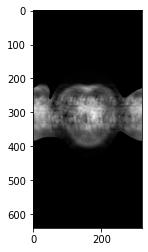

: 

: 

: 

In [ ]:
plt.imshow(np.abs(cs_data[10,:,:]), cmap='gray')


In [ ]:
# Write cs_data away
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'a') # Open in append mode!
# ...


OSError: Unable to create file (unable to open file: name = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_200_6002441.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

: 

: 

: 

In [ ]:
# R = 4
file_name = 'file_brain_AXFLAIR_209_6001340.h5'

: 

: 

: 

In [ ]:
# First, find out what the value of R is
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!
nPE_mask = hf['mask'][()]
sampled_columns = np.sum(nPE_mask)
R = len(nPE_mask)/sampled_columns
R = float(R)
print(R)


4.0


: 

: 

: 

In [ ]:
# Also, use the official test scan ACS region for the sensitivity map estimation
masked_kspace_ACS = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(masked_kspace_ACS)))
print("Datatype of the raw kspace: ", str(type(masked_kspace_ACS)))


Shape of the raw kspace:  (16, 14, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>


: 

: 

: 

In [ ]:
# Now, knowing R, create a CS kspace version from the scan's multicoil_test_full file
def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

hf = h5py.File(os.path.join(preprocessed_train_path_full, file_name), 'r') # Open in read mode!
kspace = hf['kspace'][()]
mask = generate_array(kspace.shape, closer_to_4_or_8(R), mat_file, tensor_out=False)
masked_kspace = kspace * mask + 0.0


: 

: 

: 

In [ ]:
# Now, let's preform a slice-wise ESPIRiT and CS estimation
cs_data = np.zeros((masked_kspace.shape[0], masked_kspace.shape[2], masked_kspace.shape[3]), dtype=np.complex64)

for slice in range(masked_kspace.shape[0]):
    S = estimate_sensitivity_maps(masked_kspace_ACS[slice,:,:,:])
    cs_data[slice,:,:] = CS(masked_kspace[slice,:,:,:], S)

print("Shape of the numpy-converted CS data: ", str(cs_data.shape))
print("Type of the numpy-converted CS data: ", str(type(cs_data)))


Shape of the numpy-converted CS data:  (16, 640, 320)
Type of the numpy-converted CS data:  <class 'numpy.ndarray'>


: 

: 

: 

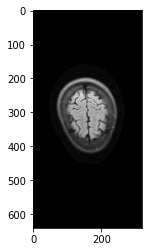

: 

: 

: 

In [ ]:
plt.imshow(np.abs(cs_data[10,:,:]), cmap='gray')


Here, we can test a loop which loops through the files in the folders we specify

In [ ]:
from pathlib import Path

folder_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file)


/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT1POST_203_6000790.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090032.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_205_6000143.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_202_6000578.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_200_6002431.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090309.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_209_6001383.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_202_2020417.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_201_6002955.

: 

: 

: 

In [ ]:
from pathlib import Path

folder_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file.name)
    print('/folder/path/'+file.name)


file_brain_AXT1POST_203_6000790.h5
/folder/path/file_brain_AXT1POST_203_6000790.h5
file_brain_AXT2_209_2090032.h5
/folder/path/file_brain_AXT2_209_2090032.h5
file_brain_AXT2_205_6000143.h5
/folder/path/file_brain_AXT2_205_6000143.h5
file_brain_AXFLAIR_202_6000578.h5
/folder/path/file_brain_AXFLAIR_202_6000578.h5
file_brain_AXT2_200_6002431.h5
/folder/path/file_brain_AXT2_200_6002431.h5
file_brain_AXT2_209_2090309.h5
/folder/path/file_brain_AXT2_209_2090309.h5
file_brain_AXFLAIR_209_6001383.h5
/folder/path/file_brain_AXFLAIR_209_6001383.h5
file_brain_AXT2_202_2020417.h5
/folder/path/file_brain_AXT2_202_2020417.h5
file_brain_AXFLAIR_201_6002955.h5
/folder/path/file_brain_AXFLAIR_201_6002955.h5
file_brain_AXT2_208_2080716.h5
/folder/path/file_brain_AXT2_208_2080716.h5
file_brain_AXT2_200_2000498.h5
/folder/path/file_brain_AXT2_200_2000498.h5
file_brain_AXFLAIR_201_6003013.h5
/folder/path/file_brain_AXFLAIR_201_6003013.h5
file_brain_AXT2_203_2030129.h5
/folder/path/file_brain_AXT2_203_2030

: 

: 

: 